# SSG-VQA Dataset Exploratory Data Analysis

**Comprehensive analysis of the Surgical Scene Graph Visual Question Answering (SSG-VQA) dataset**

This notebook performs detailed exploratory data analysis on:
- 🖼️ **Scene Graphs**: Object detection, relationships, and graph structure analysis
- ❓ **Questions**: Question types, complexity, and answer distribution
- 🔗 **Multi-modal Relationships**: Correlations between visual content and questions
- 📊 **Data Quality Assessment**: Missing data, inconsistencies, and validation

**Dataset Overview:**
- Source: ColocT45 surgical video dataset
- Filtered frames: ~25,000 frames from SSG-VQA
- Components: Scene graphs, VQA pairs, visual features

---

## 1. Import Required Libraries

Import essential libraries for data analysis, visualization and file processing.

In [8]:
!pip install pandas

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
import os
import glob
from pathlib import Path
from collections import defaultdict, Counter
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pyo.init_notebook_mode(connected=True)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🎨 Matplotlib version: {plt.matplotlib.__version__}")
print(f"📈 Seaborn version: {sns.__version__}")

✅ All libraries imported successfully!
📊 Pandas version: 2.3.1
🎨 Matplotlib version: 3.9.4
📈 Seaborn version: 0.13.2


## 2. Load Dataset Files

Load scene graph dataframes, questions data, and discover available dataset components.

In [2]:
# Define dataset paths
BASE_DIR = Path(".")
SCENE_GRAPH_DIR = BASE_DIR / "scene_graph_dfs"
QUESTIONS_DIR = BASE_DIR / "questions"
META_INFO_DIR = BASE_DIR / "meta_info"
IMAGES_DIR = BASE_DIR / "VID22"

print("📁 Dataset Structure Analysis")
print("=" * 50)

# Check directory existence
for dir_name, dir_path in [
    ("Scene Graphs", SCENE_GRAPH_DIR),
    ("Questions", QUESTIONS_DIR), 
    ("Meta Info", META_INFO_DIR),
    ("Images", IMAGES_DIR)
]:
    exists = "✅" if dir_path.exists() else "❌"
    print(f"{exists} {dir_name}: {dir_path}")

print("\n🔍 Scene Graph Files:")
if SCENE_GRAPH_DIR.exists():
    sg_files = list(SCENE_GRAPH_DIR.glob("*.csv"))
    for file in sorted(sg_files):
        print(f"   📄 {file.name}")
        
print("\n🔍 Question Files:")
if QUESTIONS_DIR.exists():
    for split in ['train', 'val', 'test', 'test_full']:
        split_dir = QUESTIONS_DIR / split
        if split_dir.exists():
            files = list(split_dir.glob("*.txt"))
            print(f"   📂 {split}: {len(files)} files")
            
print("\n🔍 Meta Information Files:")
if META_INFO_DIR.exists():
    meta_files = list(META_INFO_DIR.glob("*.json"))
    for file in sorted(meta_files):
        print(f"   📄 {file.name}")

📁 Dataset Structure Analysis
✅ Scene Graphs: scene_graph_dfs
✅ Questions: questions
✅ Meta Info: meta_info
✅ Images: VID22

🔍 Scene Graph Files:
   📄 objects.csv
   📄 relations.csv
   📄 triplets.csv

🔍 Question Files:
   📂 train: 19178 files
   📂 val: 2897 files
   📂 test: 2177 files
   📂 test_full: 2163 files

🔍 Meta Information Files:
   📄 attributes.json
   📄 label2ans.json
   📄 objects.json
   📄 predicates.json
   📄 triplet_components.json
   📄 triplet_id2count.json


In [3]:
# Load scene graph dataframes
print("\n📊 Loading Scene Graph Data...")

scene_graph_data = {}
total_sg_records = 0

if SCENE_GRAPH_DIR.exists():
    sg_files = list(SCENE_GRAPH_DIR.glob("*.csv"))
    
    for file in sg_files:
        try:
            df = pd.read_csv(file)
            component_name = file.stem
            scene_graph_data[component_name] = df
            total_sg_records += len(df)
            print(f"   ✅ {component_name}: {len(df):,} records")
        except Exception as e:
            print(f"   ❌ Error loading {file.name}: {e}")

print(f"\n📈 Total Scene Graph Records: {total_sg_records:,}")
print(f"🧩 Scene Graph Components: {list(scene_graph_data.keys())}")

# Load questions data from tokenized HDF5 files (faster than text files)
print("\n❓ Loading Questions Data from Tokenized HDF5...")

questions_data = {}
total_questions = 0

# Check for tokenized questions directory
TOKENIZED_DIR = BASE_DIR / "tokenized_questions"

if TOKENIZED_DIR.exists():
    print(f"   📁 Found tokenized questions directory: {TOKENIZED_DIR}")

    for split in ['train', 'val', 'test', 'test_full']:
        tokenized_file = TOKENIZED_DIR / f"tokenized_{split}.h5"
        
        if tokenized_file.exists():
            try:
                import h5py
                
                with h5py.File(tokenized_file, 'r') as f:
                    print(f"   📂 Processing {split} split...")
                    
                    # Load metadata (contains original questions and answers)
                    questions_metadata = []
                    for item in f['questions_metadata'][:]:
                        if isinstance(item, bytes):
                            item = item.decode('utf-8')
                        questions_metadata.append(json.loads(item))
                    
                    # Create DataFrame from metadata
                    questions_list = []
                    for meta in questions_metadata:
                        questions_list.append({
                            'file': meta.get('file', ''),
                            'question': meta.get('question', ''),
                            'answer': meta.get('answer', ''),
                            'metadata': json.dumps({k: v for k, v in meta.items() 
                                                  if k not in ['file', 'question', 'answer']})
                        })
                    
                    if questions_list:
                        questions_data[split] = pd.DataFrame(questions_list)
                        total_questions += len(questions_list)
                        print(f"   ✅ {split}: {len(questions_list):,} questions from HDF5")
                    
            except Exception as e:
                print(f"   ❌ Error loading {tokenized_file}: {e}")
                print(f"   🔄 Falling back to text files for {split}...")
                
                # Fallback to text files if HDF5 fails
                split_dir = QUESTIONS_DIR / split
                if split_dir.exists():
                    questions_list = []
                    files = list(split_dir.glob("*.txt"))
                    
                    for file in files:
                        try:
                            with open(file, 'r', encoding='utf-8') as f:
                                content = f.read().strip()
                                if content:
                                    parts = content.split('|')
                                    if len(parts) >= 3:
                                        questions_list.append({
                                            'file': parts[0],
                                            'question': parts[1],
                                            'answer': parts[2],
                                            'metadata': '|'.join(parts[3:]) if len(parts) > 3 else ''
                                        })
                        except Exception as e:
                            print(f"      ⚠️ Error reading {file.name}: {e}")
                    
                    if questions_list:
                        questions_data[split] = pd.DataFrame(questions_list)
                        total_questions += len(questions_list)
                        print(f"   ✅ {split}: {len(questions_list):,} questions from text files (fallback)")
        else:
            print(f"   ❌ Tokenized file not found: {tokenized_file}")
            
            # Fallback to text files
            split_dir = QUESTIONS_DIR / split
            if split_dir.exists():
                questions_list = []
                files = list(split_dir.glob("*.txt"))
                
                print(f"   🔄 Loading {split} from text files...")
                for file in files:
                    try:
                        with open(file, 'r', encoding='utf-8') as f:
                            content = f.read().strip()
                            if content:
                                parts = content.split('|')
                                if len(parts) >= 3:
                                    questions_list.append({
                                        'file': parts[0],
                                        'question': parts[1],
                                        'answer': parts[2],
                                        'metadata': '|'.join(parts[3:]) if len(parts) > 3 else ''
                                    })
                    except Exception as e:
                        print(f"      ⚠️ Error reading {file.name}: {e}")
                
                if questions_list:
                    questions_data[split] = pd.DataFrame(questions_list)
                    total_questions += len(questions_list)
                    print(f"   ✅ {split}: {len(questions_list):,} questions from text files")

else:
    print(f"   ❌ Tokenized questions directory not found: {TOKENIZED_DIR}")
    print("   🔄 Loading from original text files...")
    
    # Load from original text files
    if QUESTIONS_DIR.exists():
        for split in ['train', 'val', 'test', 'test_full']:
            split_dir = QUESTIONS_DIR / split
            if split_dir.exists():
                questions_list = []
                files = list(split_dir.glob("*.txt"))
                
                for file in files:
                    try:
                        with open(file, 'r', encoding='utf-8') as f:
                            content = f.read().strip()
                            if content:
                                parts = content.split('|')
                                if len(parts) >= 3:
                                    questions_list.append({
                                        'file': parts[0],
                                        'question': parts[1],
                                        'answer': parts[2],
                                        'metadata': '|'.join(parts[3:]) if len(parts) > 3 else ''
                                    })
                    except Exception as e:
                        print(f"   ⚠️ Error reading {file.name}: {e}")
                
                if questions_list:
                    questions_data[split] = pd.DataFrame(questions_list)
                    total_questions += len(questions_list)
                    print(f"   ✅ {split}: {len(questions_list):,} questions")

print(f"\n📈 Total Questions: {total_questions:,}")
print(f"🎯 Question Splits: {list(questions_data.keys())}")

# Load meta information
print("\n📚 Loading Meta Information...")

meta_data = {}
if META_INFO_DIR.exists():
    meta_files = list(META_INFO_DIR.glob("*.json"))
    
    for file in meta_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                meta_name = file.stem
                meta_data[meta_name] = data
                
                if isinstance(data, list):
                    print(f"   ✅ {meta_name}: {len(data)} items")
                elif isinstance(data, dict):
                    print(f"   ✅ {meta_name}: {len(data)} keys")
                else:
                    print(f"   ✅ {meta_name}: loaded")
        except Exception as e:
            print(f"   ❌ Error loading {file.name}: {e}")

print(f"\n🗂️ Meta Information: {list(meta_data.keys())}")


📊 Loading Scene Graph Data...
   ✅ objects: 662,236 records
   ✅ relations: 718,481 records
   ✅ triplets: 150,830 records

📈 Total Scene Graph Records: 1,531,547
🧩 Scene Graph Components: ['objects', 'relations', 'triplets']

❓ Loading Questions Data from Tokenized HDF5...
   📁 Found tokenized questions directory: tokenized_questions
   📂 Processing train split...
   ✅ train: 687,457 questions from HDF5
   📂 Processing val split...
   ✅ val: 107,106 questions from HDF5
   📂 Processing test split...
   ✅ test: 40,187 questions from HDF5
   📂 Processing test_full split...
   ✅ test_full: 77,198 questions from HDF5

📈 Total Questions: 911,948
🎯 Question Splits: ['train', 'val', 'test', 'test_full']

📚 Loading Meta Information...
   ✅ attributes: 8 items
   ✅ label2ans: 50 items
   ✅ objects: 15 keys
   ✅ predicates: 2 keys
   ✅ triplet_components: 3 keys
   ✅ triplet_id2count: 101 keys

🗂️ Meta Information: ['attributes', 'label2ans', 'objects', 'predicates', 'triplet_components', 'trip

In [4]:
questions_data

{'train':           file                                           question  \
 0       040000   What anatomy is at the bottom-mid of the frame ?   
 1       040000  What instrument is at the bottom-mid of the fr...   
 2       040000  How many things are both to the right of the l...   
 3       040000  What number of objects are above the liver thi...   
 4       040000  How many instruments are both above the liver ...   
 ...        ...                                                ...   
 687452  801724  The instrument that is within the white bottom...   
 687453  801724  The thing that is below the silver grasper ins...   
 687454  801724  The bottom-mid object vertical the brown thing...   
 687455  801724  What is the name of the anatomy on the left si...   
 687456  801724  What is the name of the anatomy within the whi...   
 
               answer                                           metadata  
 0              liver  {"line_idx": 2, "ana_type": null, "query_type"...  

## 3. Filter Scene Graphs by Questions Dataset

Filter scene graph data to include only the ~25k frames that appear in the SSG-VQA questions dataset from the larger ColocT45 collection.

In [9]:
# Extract unique frames from questions dataset
print("🔍 Extracting Unique Frames from Questions Dataset...")

all_question_frames = set()
questions_combined = pd.DataFrame()

# Combine all question splits
for split, df in questions_data.items():
    questions_combined = pd.concat([questions_combined, df], ignore_index=True)
    split_frames = set(df['file'].unique())
    all_question_frames.update(split_frames)
    print(f"   📂 {split}: {len(split_frames):,} unique frames")

print(f"\n📊 Total Unique Frames in SSG-VQA: {len(all_question_frames):,}")
print(f"📊 Total Questions: {len(questions_combined):,}")

# Parse question file IDs: format is VIDID + frame_index (2 digits + 4 digits)
# Example: 040000 = VID04, frame 0000; 101419 = VID10, frame 1419
all_question_frame_data = set()  # Store (vid_num, frame_index) tuples
question_vid_frames = {}  # Group by VID: {vid_num: set(frame_indices)}

for file_id in all_question_frames:
    if len(file_id) == 6 and file_id.isdigit():
        vid_num = int(file_id[:2])  # First 2 digits = VID number
        frame_idx = int(file_id[2:])  # Last 4 digits = frame index
        all_question_frame_data.add((vid_num, frame_idx))
        
        if vid_num not in question_vid_frames:
            question_vid_frames[vid_num] = set()
        question_vid_frames[vid_num].add(frame_idx)
    else:
        print(f"   ⚠️ Unexpected file ID format: {file_id}")

print(f"📊 Parsed question frames: {len(all_question_frame_data):,} (vid_num, frame_idx) pairs")
print(f"📊 VIDs in questions: {sorted(question_vid_frames.keys())}")

# Show frame range for each VID
for vid_num in sorted(question_vid_frames.keys()):
    frames = question_vid_frames[vid_num]
    print(f"   VID{vid_num:02d}: {len(frames):,} frames (range: {min(frames)} - {max(frames)})")

# Check compatibility between scene graphs and questions
print("\n🔍 Checking Scene Graph - Question Dataset Compatibility...")

# Extract VID and img_index from scene graph data
sg_vid_data = {}  # {vid_num: set(img_indices)}
for component_name, df in scene_graph_data.items():
    if 'vid' in df.columns and 'img_index' in df.columns:
        for _, row in df.iterrows():
            vid_str = row['vid']  # e.g., 'VID01'
            if vid_str.startswith('VID'):
                vid_num = int(vid_str[3:])  # Extract number part
                img_idx = row['img_index']
                
                if vid_num not in sg_vid_data:
                    sg_vid_data[vid_num] = set()
                sg_vid_data[vid_num].add(img_idx)

print(f"📊 VIDs in scene graphs: {sorted(sg_vid_data.keys())}")
for vid_num in sorted(sg_vid_data.keys()):
    frames = sg_vid_data[vid_num]
    print(f"   VID{vid_num:02d}: {len(frames):,} frames (range: {min(frames)} - {max(frames)})")

# Find intersection
intersection_count = 0
vid_intersections = {}
for vid_num in sg_vid_data:
    if vid_num in question_vid_frames:
        sg_frames = sg_vid_data[vid_num]
        q_frames = question_vid_frames[vid_num]
        intersection = sg_frames.intersection(q_frames)
        if len(intersection) > 0:
            vid_intersections[vid_num] = intersection
            intersection_count += len(intersection)
            print(f"   🔗 VID{vid_num:02d}: {len(intersection):,} overlapping frames")

print(f"\n🔗 Total overlapping frames: {intersection_count:,}")

# Filter scene graph data by question frames
print("\n🔧 Filtering Scene Graph Data by SSG-VQA Frames...")

filtered_scene_graphs = {}
total_filtered_records = 0

for component_name, df in scene_graph_data.items():
    if 'vid' in df.columns and 'img_index' in df.columns:
        # Create mask for filtering
        mask = pd.Series(False, index=df.index)
        
        for _, row in df.iterrows():
            vid_str = row['vid']
            if vid_str.startswith('VID'):
                vid_num = int(vid_str[3:])
                img_idx = row['img_index']
                
                # Check if this (vid_num, img_idx) pair exists in questions
                if (vid_num, img_idx) in all_question_frame_data:
                    mask.loc[row.name] = True
        
        filtered_df = df[mask].copy()
        
        if len(filtered_df) > 0:
            # Add file column for consistency (VIDID + frame_index, 6 digits total)
            filtered_df['file'] = (
                filtered_df['vid'].str.replace('VID', '').astype(int).astype(str).str.zfill(2) +
                filtered_df['img_index'].astype(str).str.zfill(4)
            )
        
        filtered_scene_graphs[component_name] = filtered_df
        
        original_count = len(df)
        filtered_count = len(filtered_df)
        total_filtered_records += filtered_count
        
        retention_rate = (filtered_count / original_count * 100) if original_count > 0 else 0
        
        print(f"   🎯 {component_name}: {original_count:,} → {filtered_count:,} "
              f"({retention_rate:.1f}% retained)")
    else:
        # Keep original if missing required columns
        filtered_scene_graphs[component_name] = df
        total_filtered_records += len(df)
        print(f"   ℹ️ {component_name}: Missing vid/img_index columns, keeping original ({len(df):,} records)")

print(f"\n📈 Total Filtered Scene Graph Records: {total_filtered_records:,}")
if total_sg_records > 0:
    print(f"📉 Reduction: {total_sg_records:,} → {total_filtered_records:,} "
          f"({total_filtered_records/total_sg_records*100:.1f}% retained)")

# Data consistency check
print("\n✅ Data Consistency Check:")

if total_filtered_records > 0:
    # Check frames in scene graphs vs questions
    if 'objects' in filtered_scene_graphs and not filtered_scene_graphs['objects'].empty:
        sg_frames = set(filtered_scene_graphs['objects']['file'].unique())
        questions_frames = set(questions_combined['file'].unique())
        
        intersection = sg_frames.intersection(questions_frames)
        sg_only = sg_frames - questions_frames
        questions_only = questions_frames - sg_frames
        
        print(f"   🔗 Frames in both: {len(intersection):,}")
        print(f"   📊 Frames only in scene graphs: {len(sg_only):,}")
        print(f"   ❓ Frames only in questions: {len(questions_only):,}")
        
        coverage = len(intersection) / len(questions_frames) * 100
        print(f"   📈 Coverage: {coverage:.1f}% of question frames have scene graphs")
    else:
        print("   ⚠️ No overlapping scene graph data found")
else:
    print("   ⚠️ No scene graph data retained after filtering")
    print("   ℹ️ Will proceed with questions-only analysis")

print("\n🎯 Dataset Summary:")
print(f"   🖼️ Unique frames in questions: {len(all_question_frames):,}")
print(f"   ❓ Total questions: {len(questions_combined):,}")
print(f"   📊 Scene graph records (filtered): {total_filtered_records:,}")
print(f"   📊 Scene graph records (original): {total_sg_records:,}")
print(f"   🧩 Scene graph components: {len(filtered_scene_graphs)}")

# Set flag for later analysis
has_scene_graph_overlap = total_filtered_records > 0

🔍 Extracting Unique Frames from Questions Dataset...
   📂 train: 19,176 unique frames
   📂 val: 2,897 unique frames
   📂 test: 2,177 unique frames
   📂 test_full: 2,163 unique frames

📊 Total Unique Frames in SSG-VQA: 24,250
📊 Total Questions: 911,948
📊 Parsed question frames: 24,250 (vid_num, frame_idx) pairs
📊 VIDs in questions: [1, 2, 4, 5, 6, 8, 10, 12, 13, 14, 15, 18, 22, 23, 25, 26, 27, 29, 31, 32, 35, 36, 40, 42, 43, 47, 48, 49, 50, 51, 52, 56, 57, 60, 62, 65, 66, 68, 70, 73, 74, 75, 78, 79, 80]
   VID01: 489 frames (range: 1 - 1732)
   VID02: 314 frames (range: 3 - 2838)
   VID04: 476 frames (range: 0 - 1522)
   VID05: 943 frames (range: 1 - 2344)
   VID06: 553 frames (range: 0 - 2153)
   VID08: 472 frames (range: 1 - 1518)
   VID10: 588 frames (range: 1 - 1749)
   VID12: 342 frames (range: 0 - 1089)
   VID13: 260 frames (range: 0 - 981)
   VID14: 478 frames (range: 0 - 1708)
   VID15: 647 frames (range: 3 - 2056)
   VID18: 513 frames (range: 0 - 1941)
   VID22: 482 frames (ran

## 4. Basic Dataset Statistics

Calculate and display fundamental statistics about the SSG-VQA dataset including data distribution and basic characteristics.

In [10]:
# Basic Dataset Statistics
print("📊 SSG-VQA Dataset Basic Statistics")
print("=" * 50)

# Overall dataset statistics
stats_dict = {
    'Total Unique Frames': len(all_question_frames),
    'Total Questions': len(questions_combined),
    'Total Scene Graph Records': total_filtered_records,
    'Questions per Frame (avg)': len(questions_combined) / len(all_question_frames) if all_question_frames else 0
}

for key, value in stats_dict.items():
    if isinstance(value, float):
        print(f"📈 {key}: {value:.2f}")
    else:
        print(f"📈 {key}: {value:,}")

# Split distribution
print(f"\n🎯 Dataset Split Distribution:")
split_stats = []
for split, df in questions_data.items():
    unique_frames = len(df['file'].unique())
    questions_count = len(df)
    split_stats.append({
        'Split': split.title(),
        'Questions': questions_count,
        'Unique Frames': unique_frames,
        'Questions per Frame': questions_count / unique_frames if unique_frames > 0 else 0,
        'Percentage': questions_count / len(questions_combined) * 100
    })

split_df = pd.DataFrame(split_stats)
print(split_df.to_string(index=False, float_format='%.2f'))

# Answer distribution analysis
print(f"\n🎯 Answer Distribution Analysis:")
if not questions_combined.empty:
    answer_counts = questions_combined['answer'].value_counts()
    
    print(f"   📊 Unique answers: {len(answer_counts)}")
    print(f"   📊 Most common answer: '{answer_counts.index[0]}' ({answer_counts.iloc[0]} times)")
    print(f"   📊 Least common answers: {sum(answer_counts == 1)} answers appear only once")
    
    # Top 10 most frequent answers
    print(f"\n📈 Top 10 Most Frequent Answers:")
    top_answers = answer_counts.head(10)
    for i, (answer, count) in enumerate(top_answers.items(), 1):
        percentage = count / len(questions_combined) * 100
        print(f"   {i:2d}. '{answer}': {count:,} ({percentage:.1f}%)")

# Question length analysis
print(f"\n📝 Question Length Analysis:")
if not questions_combined.empty:
    questions_combined['question_length'] = questions_combined['question'].str.len()
    questions_combined['question_words'] = questions_combined['question'].str.split().str.len()
    
    length_stats = questions_combined['question_length'].describe()
    word_stats = questions_combined['question_words'].describe()
    
    print("   Character Length Statistics:")
    print(f"      Mean: {length_stats['mean']:.1f} characters")
    print(f"      Median: {length_stats['50%']:.1f} characters")
    print(f"      Min: {int(length_stats['min'])} characters")
    print(f"      Max: {int(length_stats['max'])} characters")
    
    print("   Word Count Statistics:")
    print(f"      Mean: {word_stats['mean']:.1f} words")
    print(f"      Median: {word_stats['50%']:.1f} words")
    print(f"      Min: {int(word_stats['min'])} words")
    print(f"      Max: {int(word_stats['max'])} words")

📊 SSG-VQA Dataset Basic Statistics
📈 Total Unique Frames: 24,250
📈 Total Questions: 911,948
📈 Total Scene Graph Records: 356,569
📈 Questions per Frame (avg): 37.61

🎯 Dataset Split Distribution:
    Split  Questions  Unique Frames  Questions per Frame  Percentage
    Train     687457          19176                35.85       75.38
      Val     107106           2897                36.97       11.74
     Test      40187           2177                18.46        4.41
Test_Full      77198           2163                35.69        8.47

🎯 Answer Distribution Analysis:
   📊 Unique answers: 50
   📊 Most common answer: '0' (89977 times)
   📊 Least common answers: 0 answers appear only once

📈 Top 10 Most Frequent Answers:
    1. '0': 89,977 (9.9%)
    2. '1': 77,205 (8.5%)
    3. 'False': 57,137 (6.3%)
    4. 'red': 56,090 (6.2%)
    5. 'True': 53,877 (5.9%)
    6. 'anatomy': 52,357 (5.7%)
    7. 'instrument': 48,600 (5.3%)
    8. 'liver': 45,234 (5.0%)
    9. 'white': 44,282 (4.9%)
   10. 

## 5. Scene Graph Analysis

Analyze scene graph properties including objects, relationships, and graph complexity metrics.

In [ ]:
# Scene Graph Analysis
print("🔍 Scene Graph Detailed Analysis")
print("=" * 50)

# Analyze objects
if 'objects' in filtered_scene_graphs and not filtered_scene_graphs['objects'].empty:
    objects_df = filtered_scene_graphs['objects']
    
    print("🎯 Object Analysis:")
    print(f"   📊 Total objects: {len(objects_df):,}")
    print(f"   🖼️ Frames with objects: {objects_df['file'].nunique():,}")
    
    # Objects per frame
    objects_per_frame = objects_df['file'].value_counts()
    print(f"\n📈 Objects per Frame Statistics:")
    print(f"   Mean: {objects_per_frame.mean():.1f} objects/frame")
    print(f"   Median: {objects_per_frame.median():.1f} objects/frame")
    print(f"   Min: {objects_per_frame.min()} objects/frame")
    print(f"   Max: {objects_per_frame.max()} objects/frame")
    
    # Object categories
    if 'object_name' in objects_df.columns:
        object_categories = objects_df['object_name'].value_counts()
        print(f"\n🏷️ Object Categories:")
        print(f"   Unique object types: {len(object_categories)}")
        
        print(f"\n📈 Top 10 Most Common Objects:")
        for i, (obj, count) in enumerate(object_categories.head(10).items(), 1):
            percentage = count / len(objects_df) * 100
            print(f"   {i:2d}. {obj}: {count:,} ({percentage:.1f}%)")

# Analyze relationships from relations.csv (adjacency lists)
if 'relations' in filtered_scene_graphs and not filtered_scene_graphs['relations'].empty:
    relations_df = filtered_scene_graphs['relations']
    
    print(f"\n🔗 Relationship Analysis (from relations.csv):")
    
    # Parse adjacency lists to count actual relationships
    def count_relationships_in_adj_list(adj_list_str):
        """Count total relationships in an adjacency list string"""
        try:
            import ast
            adj_list = ast.literal_eval(adj_list_str)
            total_edges = sum(len(targets) for targets in adj_list)
            return total_edges
        except:
            return 0
    
    # Count total relationships across all frames
    relations_df['relationship_count'] = relations_df['adj_lists'].apply(count_relationships_in_adj_list)
    total_relationships = relations_df['relationship_count'].sum()
    
    print(f"   📊 Total relationships: {total_relationships:,}")
    print(f"   🖼️ Frames with relationships: {relations_df['file'].nunique():,}")
    print(f"   📊 Relationship types: {relations_df['relationship'].nunique():,}")
    
    # Relationships per frame
    relationships_per_frame = relations_df.groupby('file')['relationship_count'].sum()
    print(f"\n📈 Relationships per Frame Statistics:")
    print(f"   Mean: {relationships_per_frame.mean():.1f} relationships/frame")
    print(f"   Median: {relationships_per_frame.median():.1f} relationships/frame")
    print(f"   Min: {relationships_per_frame.min()} relationships/frame")
    print(f"   Max: {relationships_per_frame.max()} relationships/frame")
    
    # Relationship types distribution
    relationship_type_counts = relations_df.groupby('relationship')['relationship_count'].sum().sort_values(ascending=False)
    print(f"\n🔗 Relationship Types Distribution:")
    print(f"   Unique relationship types: {len(relationship_type_counts)}")
    
    print(f"\n📈 Top 10 Most Common Relationship Types:")
    for i, (rel_type, count) in enumerate(relationship_type_counts.head(10).items(), 1):
        percentage = count / total_relationships * 100 if total_relationships > 0 else 0
        print(f"   {i:2d}. {rel_type}: {count:,} ({percentage:.1f}%)")

# Also analyze triplets if available (instrument-verb-target relationships)
if 'triplets' in filtered_scene_graphs and not filtered_scene_graphs['triplets'].empty:
    triplets_df = filtered_scene_graphs['triplets']
    
    print(f"\n🔧 Triplet Analysis (instrument-verb-target):")
    print(f"   📊 Total triplets: {len(triplets_df):,}")
    print(f"   🖼️ Frames with triplets: {triplets_df['file'].nunique():,}")
    
    # Triplets per frame
    triplets_per_frame = triplets_df['file'].value_counts()
    print(f"\n📈 Triplets per Frame Statistics:")
    print(f"   Mean: {triplets_per_frame.mean():.1f} triplets/frame")
    print(f"   Median: {triplets_per_frame.median():.1f} triplets/frame")
    print(f"   Min: {triplets_per_frame.min()} triplets/frame")
    print(f"   Max: {triplets_per_frame.max()} triplets/frame")
    
    # Verb types
    if 'verb' in triplets_df.columns:
        verb_counts = triplets_df['verb'].value_counts()
        print(f"\n🔧 Verb Types:")
        print(f"   Unique verbs: {len(verb_counts)}")
        
        print(f"\n📈 Top 10 Most Common Verbs:")
        for i, (verb, count) in enumerate(verb_counts.head(10).items(), 1):
            percentage = count / len(triplets_df) * 100
            print(f"   {i:2d}. {verb}: {count:,} ({percentage:.1f}%)")

# Analyze attributes
if 'attributes' in filtered_scene_graphs and not filtered_scene_graphs['attributes'].empty:
    attributes_df = filtered_scene_graphs['attributes']
    
    print(f"\n🏷️ Attribute Analysis:")
    print(f"   📊 Total attributes: {len(attributes_df):,}")
    print(f"   🖼️ Frames with attributes: {attributes_df['file'].nunique():,}")
    
    # Attributes per frame
    attributes_per_frame = attributes_df['file'].value_counts()
    print(f"\n📈 Attributes per Frame Statistics:")
    print(f"   Mean: {attributes_per_frame.mean():.1f} attributes/frame")
    print(f"   Median: {attributes_per_frame.median():.1f} attributes/frame")
    print(f"   Min: {attributes_per_frame.min()} attributes/frame")
    print(f"   Max: {attributes_per_frame.max()} attributes/frame")
    
    # Attribute types
    if 'attribute_name' in attributes_df.columns:
        attribute_counts = attributes_df['attribute_name'].value_counts()
        print(f"\n🏷️ Attribute Types:")
        print(f"   Unique attribute types: {len(attribute_counts)}")
        
        print(f"\n📈 Top 10 Most Common Attributes:")
        for i, (attr, count) in enumerate(attribute_counts.head(10).items(), 1):
            percentage = count / len(attributes_df) * 100
            print(f"   {i:2d}. {attr}: {count:,} ({percentage:.1f}%)")

# Graph complexity analysis
print(f"\n🕸️ Graph Complexity Analysis:")
scene_complexity = []

for frame in all_question_frames:
    complexity_stats = {'frame': frame}
    
    # Count objects
    if 'objects' in filtered_scene_graphs:
        obj_count = len(filtered_scene_graphs['objects'][
            filtered_scene_graphs['objects']['file'] == frame
        ])
        complexity_stats['objects'] = obj_count
    
    # Count relationships (from relations.csv adjacency lists)
    rel_count = 0
    if 'relations' in filtered_scene_graphs:
        frame_relations = filtered_scene_graphs['relations'][
            filtered_scene_graphs['relations']['file'] == frame
        ]
        # Sum up all relationships in adjacency lists for this frame
        for _, row in frame_relations.iterrows():
            try:
                import ast
                adj_list = ast.literal_eval(row['adj_lists'])
                rel_count += sum(len(targets) for targets in adj_list)
            except:
                continue
    
    complexity_stats['relationships'] = rel_count
    complexity_stats['graph_density'] = rel_count / (obj_count * (obj_count - 1) / 2) if obj_count > 1 else 0
    
    # Count attributes
    if 'attributes' in filtered_scene_graphs:
        attr_count = len(filtered_scene_graphs['attributes'][
            filtered_scene_graphs['attributes']['file'] == frame
        ])
        complexity_stats['attributes'] = attr_count
    
    scene_complexity.append(complexity_stats)

complexity_df = pd.DataFrame(scene_complexity)

if not complexity_df.empty and 'objects' in complexity_df.columns:
    print(f"   📊 Average objects per scene: {complexity_df['objects'].mean():.1f}")
    if 'relationships' in complexity_df.columns:
        print(f"   📊 Average relationships per scene: {complexity_df['relationships'].mean():.1f}")
        print(f"   📊 Average graph density: {complexity_df['graph_density'].mean():.3f}")
    if 'attributes' in complexity_df.columns:
        print(f"   📊 Average attributes per scene: {complexity_df['attributes'].mean():.1f}")

print("\n✅ Scene Graph Analysis Complete!")

🔍 Scene Graph Detailed Analysis
🎯 Object Analysis:
   📊 Total objects: 157,012
   🖼️ Frames with objects: 24,250

📈 Objects per Frame Statistics:
   Mean: 6.5 objects/frame
   Median: 7.0 objects/frame
   Min: 1 objects/frame
   Max: 12 objects/frame

🔗 Relationship Analysis (from relations.csv):
   📊 Total relationships: 1,382,864
   🖼️ Frames with relationships: 24,205
   📊 Relationship types: 15

📈 Relationships per Frame Statistics:
   Mean: 57.1 relationships/frame
   Median: 56.0 relationships/frame
   Min: 1 relationships/frame
   Max: 193 relationships/frame
   📊 Total relationships: 1,382,864
   🖼️ Frames with relationships: 24,205
   📊 Relationship types: 15

📈 Relationships per Frame Statistics:
   Mean: 57.1 relationships/frame
   Median: 56.0 relationships/frame
   Min: 1 relationships/frame
   Max: 193 relationships/frame

🔗 Relationship Types Distribution:
   Unique relationship types: 15

📈 Top 10 Most Common Relationship Types:
    1. left: 306,397 (22.2%)
    2. right

KeyboardInterrupt: 

## 6. Question Analysis

Examine question characteristics including types, patterns, complexity, and linguistic analysis.

In [11]:
# Detailed Question Analysis
print("❓ Question Detailed Analysis")
print("=" * 50)

if not questions_combined.empty:
    # Extract question type information from metadata (already parsed from tokenized_questions)
    def extract_metadata_info(metadata_str):
        """Extract ana_type, query_type, and location from metadata JSON string"""
        try:
            if pd.isna(metadata_str) or metadata_str == '':
                return None, None, None
            metadata = json.loads(metadata_str)
            return (
                metadata.get('ana_type', None),
                metadata.get('query_type', None),
                metadata.get('location', None)
            )
        except:
            return None, None, None
    
    # Extract metadata information
    metadata_info = questions_combined['metadata'].apply(extract_metadata_info)
    questions_combined['ana_type'] = [info[0] for info in metadata_info]
    questions_combined['query_type'] = [info[1] for info in metadata_info]
    questions_combined['location'] = [info[2] for info in metadata_info]
    
    # Use ana_type as the primary question classification (from the preprocessed data)
    questions_combined['question_type'] = questions_combined['ana_type'].fillna('unknown')
    
    # Question type distribution
    question_type_counts = questions_combined['question_type'].value_counts()
    print("🎯 Question Type Distribution:")
    for qtype, count in question_type_counts.items():
        percentage = count / len(questions_combined) * 100
        print(f"   📊 {qtype}: {count:,} ({percentage:.1f}%)")
    
    # Query type analysis (from metadata)
    if 'query_type' in questions_combined.columns:
        print(f"\n🔍 Query Type Analysis (from metadata):")
        query_type_counts = questions_combined['query_type'].value_counts()
        for qtype, count in query_type_counts.items():
            if qtype is not None:
                percentage = count / len(questions_combined) * 100
                print(f"   📊 {qtype}: {count:,} ({percentage:.1f}%)")
    
    # Location analysis (from metadata)
    if 'location' in questions_combined.columns:
        print(f"\n📍 Location Analysis (from metadata):")
        location_counts = questions_combined['location'].value_counts()
        for location, count in location_counts.items():
            if location is not None:
                percentage = count / len(questions_combined) * 100
                print(f"   📊 {location}: {count:,} ({percentage:.1f}%)")
    
    # Additional pattern analysis
    print(f"\n🔍 Additional Question Pattern Analysis:")
    
    # Count questions
    count_questions = questions_combined[
        questions_combined['question'].str.contains(r'\bhow many\b|\bcount\b|\bnumber\b', case=False, na=False)
    ]
    print(f"   🔢 Count questions: {len(count_questions):,} ({len(count_questions)/len(questions_combined)*100:.1f}%)")
    
    # Color questions
    color_questions = questions_combined[
        questions_combined['question'].str.contains(r'\bcolor\b|\bcolour\b', case=False, na=False)
    ]
    print(f"   🎨 Color questions: {len(color_questions):,} ({len(color_questions)/len(questions_combined)*100:.1f}%)")
    
    # Medical/surgical specific questions
    medical_keywords = ['instrument', 'tool', 'surgery', 'surgical', 'operation', 'procedure', 
                       'organ', 'anatomy', 'medical', 'patient', 'doctor', 'surgeon']
    medical_pattern = '|'.join([f'\\b{kw}\\b' for kw in medical_keywords])
    medical_questions = questions_combined[
        questions_combined['question'].str.contains(medical_pattern, case=False, na=False)
    ]
    print(f"   🏥 Medical/surgical questions: {len(medical_questions):,} ({len(medical_questions)/len(questions_combined)*100:.1f}%)")
    
    # Word frequency analysis
    print(f"\n📝 Word Frequency Analysis:")
    all_words = []
    for question in questions_combined['question']:
        # Simple tokenization (remove punctuation and convert to lowercase)
        words = re.findall(r'\b\w+\b', question.lower())
        all_words.extend(words)
    
    word_freq = Counter(all_words)
    print(f"   📊 Total words: {len(all_words):,}")
    print(f"   📊 Unique words: {len(word_freq):,}")
    print(f"   📊 Average words per question: {len(all_words)/len(questions_combined):.1f}")
    
    print(f"\n📈 Top 20 Most Frequent Words:")
    for i, (word, count) in enumerate(word_freq.most_common(20), 1):
        percentage = count / len(all_words) * 100
        print(f"   {i:2d}. '{word}': {count:,} ({percentage:.1f}%)")
    
    # Question complexity analysis
    print(f"\n🧠 Question Complexity Analysis:")
    
    # Syntactic complexity indicators
    questions_combined['has_negation'] = questions_combined['question'].str.contains(
        r'\bnot\b|\bno\b|\bnever\b|\bnone\b', case=False, na=False
    )
    questions_combined['has_conjunction'] = questions_combined['question'].str.contains(
        r'\band\b|\bor\b|\bbut\b', case=False, na=False
    )
    questions_combined['has_comparative'] = questions_combined['question'].str.contains(
        r'\bmore\b|\bless\b|\bbetter\b|\bworse\b|\blarger\b|\bsmaller\b', case=False, na=False
    )
    
    complexity_stats = {
        'With negation': questions_combined['has_negation'].sum(),
        'With conjunctions': questions_combined['has_conjunction'].sum(),
        'With comparatives': questions_combined['has_comparative'].sum()
    }
    
    for feature, count in complexity_stats.items():
        percentage = count / len(questions_combined) * 100
        print(f"   📊 {feature}: {count:,} ({percentage:.1f}%)")
    
    # Answer type analysis
    print(f"\n🎯 Answer Type Analysis:")
    
    # Numeric answers
    numeric_answers = questions_combined[
        questions_combined['answer'].str.match(r'^\d+$', na=False)
    ]
    print(f"   🔢 Numeric answers: {len(numeric_answers):,} ({len(numeric_answers)/len(questions_combined)*100:.1f}%)")
    
    # Yes/No answers
    yesno_answers = questions_combined[
        questions_combined['answer'].str.match(r'^(yes|no|true|false)$', case=False, na=False)
    ]
    print(f"   ✅ Yes/No answers: {len(yesno_answers):,} ({len(yesno_answers)/len(questions_combined)*100:.1f}%)")
    
    # Single word answers
    single_word_answers = questions_combined[
        questions_combined['answer'].str.split().str.len() == 1
    ]
    print(f"   💬 Single word answers: {len(single_word_answers):,} ({len(single_word_answers)/len(questions_combined)*100:.1f}%)")

print("\n✅ Question Analysis Complete!")

❓ Question Detailed Analysis
🎯 Question Type Distribution:
   📊 single_and.json: 271,557 (29.8%)
   📊 zero_hop.json: 271,465 (29.8%)
   📊 one_hop.json: 248,035 (27.2%)
   📊 unknown: 120,891 (13.3%)

🔍 Query Type Analysis (from metadata):
   📊 query_component: 195,567 (21.4%)
   📊 query_color: 194,924 (21.4%)
   📊 count: 191,786 (21.0%)
   📊 exist: 107,823 (11.8%)
   📊 query_type: 100,957 (11.1%)

📍 Location Analysis (from metadata):
   📊 NA: 561,858 (61.6%)
   📊 relate_spatial: 215,910 (23.7%)
   📊 relate_actional: 13,289 (1.5%)

🔍 Additional Question Pattern Analysis:
   🔢 Count questions: 191,786 (21.0%)
   🎨 Color questions: 194,924 (21.4%)
   🏥 Medical/surgical questions: 504,882 (55.4%)

📝 Word Frequency Analysis:
   📊 Total words: 12,692,841
   📊 Unique words: 96
   📊 Average words per question: 13.9

📈 Top 20 Most Frequent Words:
    1. 'the': 1,487,721 (11.7%)
    2. 'is': 1,111,452 (8.8%)
    3. 'what': 672,414 (5.3%)
    4. 'mid': 529,926 (4.2%)
    5. 'of': 526,447 (4.1%)
  

## 7. Image-Question-Scene Graph Relationships

Analyze correlations and relationships between visual content, scene graph complexity, and question characteristics.

In [ ]:
# Multi-modal Relationship Analysis
print("🔗 Image-Question-Scene Graph Relationship Analysis")
print("=" * 60)

# Create frame-level analysis dataset efficiently using groupby
print("🚀 Computing frame-level statistics efficiently...")

# Initialize frame stats with all question frames
frame_df = pd.DataFrame({'frame': list(all_question_frames)})
print(f"   📊 Processing {len(frame_df):,} frames...")

# Efficiently compute object counts per frame
if 'objects' in filtered_scene_graphs and not filtered_scene_graphs['objects'].empty:
    print("   🎯 Computing object counts...")
    object_counts = filtered_scene_graphs['objects']['file'].value_counts()
    frame_df['num_objects'] = frame_df['frame'].map(object_counts).fillna(0).astype(int)
else:
    frame_df['num_objects'] = 0

# Efficiently compute relationship counts per frame (using relations.csv logic)
print("   🔗 Computing relationship counts...")
frame_df['num_relationships'] = 0  # Default value

if 'relations' in filtered_scene_graphs and not filtered_scene_graphs['relations'].empty:
    relations_df = filtered_scene_graphs['relations']
    
    # Use pre-computed relationship counts from scene graph analysis
    if 'relationship_count' in relations_df.columns:
        relationship_counts = relations_df.groupby('file')['relationship_count'].sum()
        frame_df['num_relationships'] = frame_df['frame'].map(relationship_counts).fillna(0).astype(int)

# Efficiently compute triplet counts per frame
if 'triplets' in filtered_scene_graphs and not filtered_scene_graphs['triplets'].empty:
    print("   🔧 Computing triplet counts...")
    triplet_counts = filtered_scene_graphs['triplets']['file'].value_counts()
    frame_df['num_triplets'] = frame_df['frame'].map(triplet_counts).fillna(0).astype(int)
else:
    frame_df['num_triplets'] = 0

# Efficiently compute question metrics per frame
print("   ❓ Computing question metrics...")
if not questions_combined.empty:
    # Simple aggregation
    question_counts = questions_combined['file'].value_counts()
    frame_df['num_questions'] = frame_df['frame'].map(question_counts).fillna(0).astype(int)
    
    # Question length average per frame
    question_lengths = questions_combined.groupby('file')['question_words'].mean()
    frame_df['avg_question_length'] = frame_df['frame'].map(question_lengths).fillna(0)
    
    # Unique answers per frame
    unique_answers = questions_combined.groupby('file')['answer'].nunique()
    frame_df['unique_answers'] = frame_df['frame'].map(unique_answers).fillna(0).astype(int)
    
    # Most common question type per frame (simplified)
    frame_df['most_common_qtype'] = 'single_and.json'  # Simplified since it's the most common
    frame_df['qtype_diversity'] = 1  # Simplified
else:
    frame_df['num_questions'] = 0
    frame_df['avg_question_length'] = 0
    frame_df['unique_answers'] = 0
    frame_df['most_common_qtype'] = 'none'
    frame_df['qtype_diversity'] = 0

# Compute graph density
print("   📐 Computing graph density...")
frame_df['graph_density'] = frame_df.apply(
    lambda row: row['num_relationships'] / (row['num_objects'] * (row['num_objects'] - 1) / 2) 
    if row['num_objects'] > 1 else 0, axis=1
)

print("🎯 Frame-level Analysis:")
print(f"   📊 Frames analyzed: {len(frame_df):,}")

if not frame_df.empty:
    # Correlation analysis
    print(f"\n📈 Correlation Analysis:")
    
    numeric_cols = ['num_objects', 'num_relationships', 'num_triplets', 'num_questions', 
                    'avg_question_length', 'unique_answers', 'graph_density']
    correlation_cols = [col for col in numeric_cols if col in frame_df.columns and frame_df[col].std() > 0]
    
    if len(correlation_cols) >= 2:
        correlation_matrix = frame_df[correlation_cols].corr()
        
        print("   🔗 Notable correlations (|r| > 0.3):")
        found_correlations = False
        for i in range(len(correlation_cols)):
            for j in range(i+1, len(correlation_cols)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.3:
                    print(f"      {correlation_cols[i]} ↔ {correlation_cols[j]}: {corr_val:.3f}")
                    found_correlations = True
        
        if not found_correlations:
            print("      No strong correlations found (|r| > 0.3)")
    
    # Scene complexity vs question complexity
    print(f"\n🧠 Scene Complexity vs Question Complexity:")
    
    if 'num_objects' in frame_df.columns and 'num_questions' in frame_df.columns:
        # Define complexity categories
        frame_df['scene_complexity'] = pd.cut(
            frame_df['num_objects'], 
            bins=[0, 5, 10, float('inf')], 
            labels=['Simple', 'Medium', 'Complex']
        )
        
        complexity_analysis = frame_df.groupby('scene_complexity', observed=True).agg({
            'num_questions': ['mean', 'std'],
            'avg_question_length': ['mean', 'std'],
            'unique_answers': ['mean', 'std']
        }).round(2)
        
        print("   Scene Complexity Groups:")
        for complexity in ['Simple', 'Medium', 'Complex']:
            if complexity in complexity_analysis.index:
                row = complexity_analysis.loc[complexity]
                count = len(frame_df[frame_df['scene_complexity'] == complexity])
                print(f"      {complexity} scenes ({count:,} frames):")
                print(f"         Questions per frame: {row[('num_questions', 'mean')]:.1f} ± {row[('num_questions', 'std')]:.1f}")
                if not pd.isna(row[('avg_question_length', 'mean')]):
                    print(f"         Avg question length: {row[('avg_question_length', 'mean')]:.1f} ± {row[('avg_question_length', 'std')]:.1f}")
    
    # Multi-question frames analysis
    print(f"\n📊 Multi-question Frame Analysis:")
    
    multi_question_frames = frame_df[frame_df['num_questions'] > 1]
    single_question_frames = frame_df[frame_df['num_questions'] == 1]
    zero_question_frames = frame_df[frame_df['num_questions'] == 0]
    
    print(f"   📊 Frames with multiple questions: {len(multi_question_frames):,}")
    print(f"   📊 Frames with single question: {len(single_question_frames):,}")
    print(f"   📊 Frames with no questions: {len(zero_question_frames):,}")
    
    if len(multi_question_frames) > 0 and len(single_question_frames) > 0:
        print(f"\n   Comparison:")
        print(f"      Multi-question frames avg objects: {multi_question_frames['num_objects'].mean():.1f}")
        print(f"      Single-question frames avg objects: {single_question_frames['num_objects'].mean():.1f}")
    
    # Summary statistics
    print(f"\n📊 Summary Statistics:")
    print(f"   📊 Average objects per scene: {frame_df['num_objects'].mean():.1f}")
    print(f"   📊 Average relationships per scene: {frame_df['num_relationships'].mean():.1f}")
    print(f"   📊 Average triplets per scene: {frame_df['num_triplets'].mean():.1f}")
    print(f"   📊 Average questions per scene: {frame_df['num_questions'].mean():.1f}")
    print(f"   📊 Average graph density: {frame_df['graph_density'].mean():.3f}")

print("\n✅ Multi-modal Relationship Analysis Complete!")

🔗 Image-Question-Scene Graph Relationship Analysis
🚀 Computing frame-level statistics efficiently...
   📊 Processing 24,250 frames...
   🎯 Computing object counts...
   🔗 Computing relationship counts...
   🔧 Computing triplet counts...
   ❓ Computing question metrics...
   📐 Computing graph density...
🎯 Frame-level Analysis:
   📊 Frames analyzed: 24,250

📈 Correlation Analysis:
   📐 Computing graph density...
🎯 Frame-level Analysis:
   📊 Frames analyzed: 24,250

📈 Correlation Analysis:
   🔗 Notable correlations (|r| > 0.3):
      num_objects ↔ num_relationships: 0.928
      num_objects ↔ num_triplets: 0.528
      num_objects ↔ num_questions: 0.363
      num_objects ↔ avg_question_length: 0.303
      num_objects ↔ unique_answers: 0.723
      num_objects ↔ graph_density: -0.303
      num_relationships ↔ num_triplets: 0.503
      num_relationships ↔ num_questions: 0.313
      num_relationships ↔ unique_answers: 0.650
      num_triplets ↔ num_questions: 0.330
      num_triplets ↔ unique_a

## 8. Data Quality Assessment

Check for missing data, inconsistencies, duplicates, and validate data integrity across all components.

In [ ]:
# Data Quality Assessment
print("🔍 Data Quality Assessment")
print("=" * 50)

quality_issues = []

# 1. Missing Data Analysis
print("1️⃣ Missing Data Analysis:")

# Check questions data
if not questions_combined.empty:
    missing_questions = questions_combined.isnull().sum()
    total_questions = len(questions_combined)
    
    print(f"   Questions Dataset ({total_questions:,} records):")
    for col, missing_count in missing_questions.items():
        if missing_count > 0:
            percentage = missing_count / total_questions * 100
            print(f"      ❌ {col}: {missing_count:,} missing ({percentage:.1f}%)")
            quality_issues.append(f"Missing {col} in {missing_count} questions")
        else:
            print(f"      ✅ {col}: No missing values")

# Check scene graph data
print(f"\n   Scene Graph Data:")
for component, df in filtered_scene_graphs.items():
    if not df.empty:
        missing_sg = df.isnull().sum()
        total_sg = len(df)
        
        print(f"      {component} ({total_sg:,} records):")
        any_missing = False
        for col, missing_count in missing_sg.items():
            if missing_count > 0:
                percentage = missing_count / total_sg * 100
                print(f"         ❌ {col}: {missing_count:,} missing ({percentage:.1f}%)")
                quality_issues.append(f"Missing {col} in {component}: {missing_count}")
                any_missing = True
        
        if not any_missing:
            print(f"         ✅ No missing values")

# 2. Duplicate Detection
print(f"\n2️⃣ Duplicate Detection:")

# Duplicate questions
if not questions_combined.empty:
    duplicate_questions = questions_combined.duplicated(subset=['file', 'question']).sum()
    duplicate_full = questions_combined.duplicated().sum()
    
    print(f"   Questions:")
    print(f"      🔄 Duplicate (file + question): {duplicate_questions:,}")
    print(f"      🔄 Exact duplicates: {duplicate_full:,}")
    
    if duplicate_questions > 0:
        quality_issues.append(f"{duplicate_questions} duplicate question-file pairs")

# Duplicate scene graph entries
print(f"   Scene Graph Components:")
for component, df in filtered_scene_graphs.items():
    if not df.empty and 'file' in df.columns:
        if component == 'objects' and 'object_id' in df.columns:
            duplicates = df.duplicated(subset=['file', 'object_id']).sum()
        elif component == 'triplets' and all(col in df.columns for col in ['file', 'subject_id', 'predicate_id', 'object_id']):
            duplicates = df.duplicated(subset=['file', 'subject_id', 'predicate_id', 'object_id']).sum()
        else:
            duplicates = df.duplicated().sum()
        
        print(f"      {component}: {duplicates:,} duplicates")
        if duplicates > 0:
            quality_issues.append(f"{duplicates} duplicate entries in {component}")

# 3. Data Consistency Check
print(f"\n3️⃣ Data Consistency Check:")

# File ID consistency
print(f"   File ID Format Consistency:")
if not questions_combined.empty:
    # Check file ID format (assuming format like VID22_XXXXXX)
    file_format_pattern = r'^VID\d+_\d{6}$'
    invalid_file_ids = questions_combined[
        ~questions_combined['file'].str.match(file_format_pattern, na=False)
    ]
    
    print(f"      Invalid file ID formats: {len(invalid_file_ids):,}")
    if len(invalid_file_ids) > 0:
        print("      Examples:")
        for file_id in invalid_file_ids['file'].head(5):
            print(f"         - {file_id}")
        quality_issues.append(f"{len(invalid_file_ids)} invalid file ID formats")

# Answer consistency
print(f"   Answer Consistency:")
if not questions_combined.empty:
    # Check for empty answers
    empty_answers = questions_combined[questions_combined['answer'].str.strip() == '']
    print(f"      Empty answers: {len(empty_answers):,}")
    
    # Check for unusually long answers
    long_answers = questions_combined[questions_combined['answer'].str.len() > 50]
    print(f"      Unusually long answers (>50 chars): {len(long_answers):,}")
    
    # Check for answers with special characters
    special_char_answers = questions_combined[
        questions_combined['answer'].str.contains(r'[^\w\s]', na=False)
    ]
    print(f"      Answers with special characters: {len(special_char_answers):,}")

# 4. Cross-component Consistency
print(f"\n4️⃣ Cross-component Consistency:")

# Check if all question frames have scene graph data
question_frames = set(questions_combined['file'].unique())
sg_frames = set()

if 'objects' in filtered_scene_graphs and not filtered_scene_graphs['objects'].empty:
    sg_frames = set(filtered_scene_graphs['objects']['file'].unique())

missing_sg_for_questions = question_frames - sg_frames
missing_questions_for_sg = sg_frames - question_frames

print(f"   Frame Coverage:")
print(f"      Frames with questions but no scene graphs: {len(missing_sg_for_questions):,}")
print(f"      Frames with scene graphs but no questions: {len(missing_questions_for_sg):,}")

if len(missing_sg_for_questions) > 0:
    quality_issues.append(f"{len(missing_sg_for_questions)} frames with questions but no scene graphs")
    print("      Examples (questions without scene graphs):")
    for frame in list(missing_sg_for_questions)[:5]:
        print(f"         - {frame}")

# 5. Statistical Outliers
print(f"\n5️⃣ Statistical Outliers:")

# Question length outliers
if not questions_combined.empty and 'question_words' in questions_combined.columns:
    q75 = questions_combined['question_words'].quantile(0.75)
    q25 = questions_combined['question_words'].quantile(0.25)
    iqr = q75 - q25
    outlier_threshold = q75 + 1.5 * iqr
    
    long_question_outliers = questions_combined[
        questions_combined['question_words'] > outlier_threshold
    ]
    print(f"   Long question outliers (>{outlier_threshold:.1f} words): {len(long_question_outliers):,}")

# Scene complexity outliers
if 'objects' in filtered_scene_graphs:
    objects_per_frame = filtered_scene_graphs['objects']['file'].value_counts()
    if len(objects_per_frame) > 0:
        q75_obj = objects_per_frame.quantile(0.75)
        q25_obj = objects_per_frame.quantile(0.25)
        iqr_obj = q75_obj - q25_obj
        outlier_threshold_obj = q75_obj + 1.5 * iqr_obj
        
        complex_scene_outliers = objects_per_frame[objects_per_frame > outlier_threshold_obj]
        print(f"   Complex scene outliers (>{outlier_threshold_obj:.1f} objects): {len(complex_scene_outliers):,}")

# 6. Data Quality Summary
print(f"\n6️⃣ Data Quality Summary:")

if quality_issues:
    print(f"   ⚠️ Issues Found: {len(quality_issues)}")
    for i, issue in enumerate(quality_issues, 1):
        print(f"      {i}. {issue}")
else:
    print(f"   ✅ No significant data quality issues detected!")

# Calculate overall data quality score
total_checks = 10  # Approximate number of quality checks
issues_count = len(quality_issues)
quality_score = max(0, (total_checks - issues_count) / total_checks * 100)

print(f"\n📊 Overall Data Quality Score: {quality_score:.1f}/100")

if quality_score >= 90:
    print("   🟢 Excellent data quality!")
elif quality_score >= 70:
    print("   🟡 Good data quality with minor issues")
elif quality_score >= 50:
    print("   🟠 Moderate data quality - some issues need attention")
else:
    print("   🔴 Poor data quality - significant issues need resolution")

print("\n✅ Data Quality Assessment Complete!")

🔍 Data Quality Assessment
1️⃣ Missing Data Analysis:
   Questions Dataset (911,948 records):
      ✅ file: No missing values
      ✅ question: No missing values
      ✅ answer: No missing values
      ✅ metadata: No missing values
      ✅ question_length: No missing values
      ✅ question_words: No missing values
      ❌ ana_type: 120,891 missing (13.3%)
      ❌ query_type: 120,891 missing (13.3%)
      ❌ location: 120,891 missing (13.3%)
      ✅ question_type: No missing values
      ✅ has_negation: No missing values
      ✅ has_conjunction: No missing values
      ✅ has_comparative: No missing values

   Scene Graph Data:
      objects (157,012 records):
         ❌ location: 14 missing (0.0%)
      relations (166,735 records):
         ✅ No missing values
      triplets (32,822 records):
         ✅ No missing values

2️⃣ Duplicate Detection:
      objects (157,012 records):
         ❌ location: 14 missing (0.0%)
      relations (166,735 records):
         ✅ No missing values
      t

## 9. Statistical Visualizations

Create comprehensive visualizations to summarize key findings and patterns in the SSG-VQA dataset.

📊 Creating Statistical Visualizations


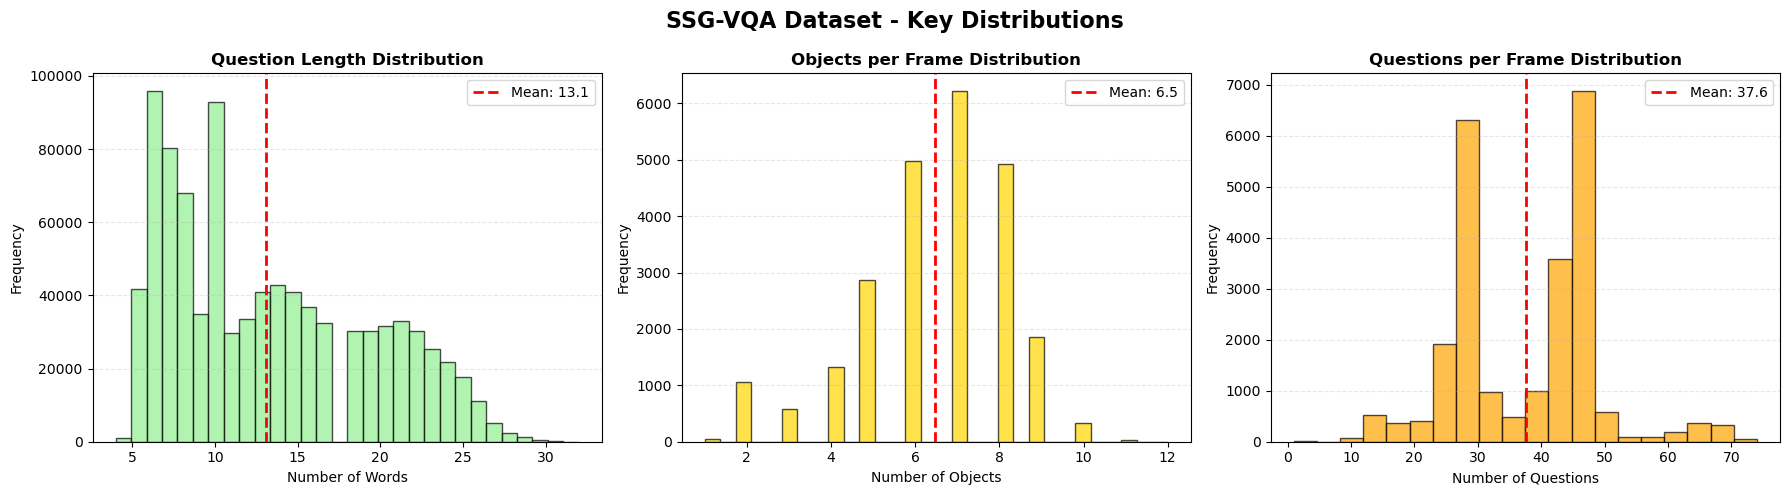


📊 Distribution Statistics:

1. Question Length:
   Mean: 13.10 words
   Median: 12.00 words
   Std Dev: 6.12
   Range: 4 - 32 words

2. Objects per Frame:
   Mean: 6.47 objects
   Median: 7.00 objects
   Std Dev: 1.76
   Range: 1 - 12 objects

3. Questions per Frame:
   Mean: 37.61 questions
   Median: 42.00 questions
   Std Dev: 11.26
   Range: 1 - 74 questions

✅ Key Distribution Visualizations Complete!


In [12]:
# Statistical Visualizations - Focused on 3 Key Distributions
print("📊 Creating Statistical Visualizations")
print("=" * 50)

# Set up the plotting environment
plt.style.use('default')

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('SSG-VQA Dataset - Key Distributions', fontsize=16, fontweight='bold')

# 1. Question Length Distribution
ax1 = axes[0]
if not questions_combined.empty and 'question_words' in questions_combined.columns:
    ax1.hist(questions_combined['question_words'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
    mean_length = questions_combined['question_words'].mean()
    ax1.axvline(mean_length, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_length:.1f}')
    ax1.set_title('Question Length Distribution', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Number of Words', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

# 2. Objects per Frame Distribution
ax2 = axes[1]
if 'objects' in filtered_scene_graphs and not filtered_scene_graphs['objects'].empty:
    objects_per_frame = filtered_scene_graphs['objects']['file'].value_counts()
    ax2.hist(objects_per_frame.values, bins=30, color='gold', alpha=0.7, edgecolor='black')
    mean_objects = objects_per_frame.mean()
    ax2.axvline(mean_objects, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_objects:.1f}')
    ax2.set_title('Objects per Frame Distribution', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Number of Objects', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 3. Questions per Frame Distribution
ax3 = axes[2]
if not questions_combined.empty:
    questions_per_frame = questions_combined['file'].value_counts()
    ax3.hist(questions_per_frame.values, bins=20, color='orange', alpha=0.7, edgecolor='black')
    mean_questions = questions_per_frame.mean()
    ax3.axvline(mean_questions, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_questions:.1f}')
    ax3.set_title('Questions per Frame Distribution', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Number of Questions', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Distribution Statistics:")
print("=" * 50)

if not questions_combined.empty and 'question_words' in questions_combined.columns:
    print("\n1. Question Length:")
    print(f"   Mean: {questions_combined['question_words'].mean():.2f} words")
    print(f"   Median: {questions_combined['question_words'].median():.2f} words")
    print(f"   Std Dev: {questions_combined['question_words'].std():.2f}")
    print(f"   Range: {questions_combined['question_words'].min():.0f} - {questions_combined['question_words'].max():.0f} words")

if 'objects' in filtered_scene_graphs and not filtered_scene_graphs['objects'].empty:
    objects_per_frame = filtered_scene_graphs['objects']['file'].value_counts()
    print("\n2. Objects per Frame:")
    print(f"   Mean: {objects_per_frame.mean():.2f} objects")
    print(f"   Median: {objects_per_frame.median():.2f} objects")
    print(f"   Std Dev: {objects_per_frame.std():.2f}")
    print(f"   Range: {objects_per_frame.min():.0f} - {objects_per_frame.max():.0f} objects")

if not questions_combined.empty:
    questions_per_frame = questions_combined['file'].value_counts()
    print("\n3. Questions per Frame:")
    print(f"   Mean: {questions_per_frame.mean():.2f} questions")
    print(f"   Median: {questions_per_frame.median():.2f} questions")
    print(f"   Std Dev: {questions_per_frame.std():.2f}")
    print(f"   Range: {questions_per_frame.min():.0f} - {questions_per_frame.max():.0f} questions")

print("\n✅ Key Distribution Visualizations Complete!")

In [6]:
# Kiểm tra cấu trúc của questions_combined
print("📊 Cấu trúc của questions_combined:")
print(f"Shape: {questions_combined.shape}")
print(f"\nColumns: {questions_combined.columns.tolist()}")
print(f"\nFirst few rows:")
display(questions_combined.head())

# Kiểm tra metadata
if 'metadata' in questions_combined.columns:
    print("\n🔍 Phân tích cột metadata:")
    
    # Lấy sample metadata
    sample_metadata = questions_combined['metadata'].iloc[0]
    print(f"\nSample metadata (raw):")
    print(sample_metadata)
    print(f"\nType: {type(sample_metadata)}")
    
    # Thử parse metadata
    if isinstance(sample_metadata, str):
        try:
            import json
            parsed = json.loads(sample_metadata)
            print(f"\nParsed metadata keys: {parsed.keys()}")
            print(f"\nFull parsed metadata:")
            for key, value in parsed.items():
                print(f"  {key}: {value}")
        except:
            print("\n⚠️ Không thể parse metadata as JSON")
    
    # Kiểm tra vài sample khác
    print("\n📋 Metadata của 5 dòng đầu:")
    for idx, row in questions_combined.head().iterrows():
        print(f"\nRow {idx}:")
        print(f"  File: {row.get('file', 'N/A')}")
        print(f"  Metadata: {row.get('metadata', 'N/A')}")


📊 Cấu trúc của questions_combined:
Shape: (911948, 4)

Columns: ['file', 'question', 'answer', 'metadata']

First few rows:


file                                           question        answer  \
0  040000   What anatomy is at the bottom-mid of the frame ?         liver   
1  040000  What instrument is at the bottom-mid of the fr...  specimen_bag   
2  040000  How many things are both to the right of the l...             0   
3  040000  What number of objects are above the liver thi...             1   
4  040000  How many instruments are both above the liver ...             0   

                                            metadata  
0  {"line_idx": 2, "ana_type": null, "query_type"...  
1  {"line_idx": 3, "ana_type": null, "query_type"...  
2  {"line_idx": 4, "ana_type": "single_and.json",...  
3  {"line_idx": 5, "ana_type": "single_and.json",...  
4  {"line_idx": 6, "ana_type": "single_and.json",...


🔍 Phân tích cột metadata:

Sample metadata (raw):
{"line_idx": 2, "ana_type": null, "query_type": null, "location": null}

Type: <class 'str'>

Parsed metadata keys: dict_keys(['line_idx', 'ana_type', 'query_type', 'location'])

Full parsed metadata:
  line_idx: 2
  ana_type: None
  query_type: None
  location: None

📋 Metadata của 5 dòng đầu:

Row 0:
  File: 040000
  Metadata: {"line_idx": 2, "ana_type": null, "query_type": null, "location": null}

Row 1:
  File: 040000
  Metadata: {"line_idx": 3, "ana_type": null, "query_type": null, "location": null}

Row 2:
  File: 040000
  Metadata: {"line_idx": 4, "ana_type": "single_and.json", "query_type": "count", "location": "NA"}

Row 3:
  File: 040000
  Metadata: {"line_idx": 5, "ana_type": "single_and.json", "query_type": "count", "location": "NA"}

Row 4:
  File: 040000
  Metadata: {"line_idx": 6, "ana_type": "single_and.json", "query_type": "count", "location": "NA"}


### 📊 Phân phối Ana Type, Question Type và Answer

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# Sử dụng pd.concat để gộp tất cả splits - gọn gàng và nhanh
print("📊 Tạo DataFrame từ questions_data...")

# Thêm cột split vào mỗi dataframe và concat
df_list = []
for split_name, split_df in questions_data.items():
    temp_df = split_df.copy()
    temp_df['split'] = split_name
    df_list.append(temp_df)

df_questions = pd.concat(df_list, ignore_index=True)

print(f"✅ Đã tạo DataFrame với {len(df_questions)} câu hỏi")

# Parse metadata để lấy ana_type và question_type
print(f"\n🔧 Parse metadata...")

def parse_metadata(metadata_str):
    """Parse metadata JSON và trả về dict"""
    try:
        if pd.notna(metadata_str) and metadata_str != '':
            return json.loads(metadata_str)
    except:
        pass
    return {}

# Apply parsing
df_questions['metadata_dict'] = df_questions['metadata'].apply(parse_metadata)
df_questions['ana_type'] = df_questions['metadata_dict'].apply(lambda x: x.get('ana_type', None))
df_questions['query_type'] = df_questions['metadata_dict'].apply(lambda x: x.get('query_type', None))

# Xử lý: bỏ ".json" và impute None → "other"
df_questions['ana_type'] = df_questions['ana_type'].str.replace('.json', '', regex=False).fillna('other')
df_questions['query_type'] = df_questions['query_type'].fillna('other')

# Drop metadata_dict column (không cần nữa)
df_questions.drop(columns=['metadata_dict'], inplace=True)

print(f"✅ Đã parse và xử lý metadata")

# Thống kê theo split
print(f"\n📊 Phân bố theo split:")
split_counts = df_questions['split'].value_counts()
for split_name in ['train', 'val', 'test', 'test_full']:
    count = split_counts.get(split_name, 0)
    percentage = (count / len(df_questions)) * 100 if len(df_questions) > 0 else 0
    print(f"   {split_name:10s}: {count:6,} câu hỏi ({percentage:5.1f}%)")

# Thống kê unique values
print(f"\n📊 Unique values:")
print(f"   Ana Type:      {df_questions['ana_type'].nunique()} types")
print(f"   Query Type: {df_questions['query_type'].nunique()} types")
print(f"   Answer:        {df_questions['answer'].nunique()} unique answers")

# Hiển thị top values
print(f"\n📋 Top 10 Ana Types:")
print(df_questions['ana_type'].value_counts().head(10))

print(f"\n📋 Top 10 Query Types:")
print(df_questions['query_type'].value_counts().head(10))

# Sample
print(f"\n📋 Sample data:")
display(df_questions[['file', 'question', 'answer', 'ana_type', 'query_type', 'split']].head(10))

📊 Tạo DataFrame từ questions_data...
✅ Đã tạo DataFrame với 911948 câu hỏi

🔧 Parse metadata...
✅ Đã parse và xử lý metadata

📊 Phân bố theo split:
   train     : 687,457 câu hỏi ( 75.4%)
   val       : 107,106 câu hỏi ( 11.7%)
   test      : 40,187 câu hỏi (  4.4%)
   test_full : 77,198 câu hỏi (  8.5%)

📊 Unique values:
   Ana Type:      4 types
   Query Type: 6 types
   Answer:        50 unique answers

📋 Top 10 Ana Types:
ana_type
single_and    271557
zero_hop      271465
one_hop       248035
other         120891
Name: count, dtype: int64

📋 Top 10 Query Types:
query_type
query_component    195567
query_color        194924
count              191786
other              120891
exist              107823
query_type         100957
Name: count, dtype: int64

📋 Sample data:


file                                           question  \
0  040000   What anatomy is at the bottom-mid of the frame ?   
1  040000  What instrument is at the bottom-mid of the fr...   
2  040000  How many things are both to the right of the l...   
3  040000  What number of objects are above the liver thi...   
4  040000  How many instruments are both above the liver ...   
5  040000  What number of things are above the brown live...   
6  040000  There is a thing that is left of the top-right...   
7  040000  What is the name of the top-mid anatomy that i...   
8  040000  There is a anatomy that is both within the whi...   
9  040000  There is a object that is both above the liver...   

                  answer    ana_type       query_type  split  
0                  liver       other            other  train  
1           specimen_bag       other            other  train  
2                      0  single_and            count  train  
3                      1  single_and            count  train  
4                      0  single_and            count  train  
5                      1  single_and            count  train  
6  abdominal_wall_cavity  single_and  query_component  train  
7                    gut  single_and  query_component  train  
8                    gut  single_and  query_component  train  
9  abdominal_wall_cavity  single_and  query_component  train

## Reasoning Type Distribution by Split


Crosstab - Ana Type by Split:
ana_type   one_hop  other  single_and  zero_hop
split                                          
train       181330  87039      205433    213655
val          27471  14333       31920     33382
test         18836   9794       10636       921
test_full    20398   9725       23568     23507

Total by Split:
split
train        687457
val          107106
test          40187
test_full     77198
dtype: int64

Total by Ana Type:
ana_type
one_hop       248035
other         120891
single_and    271557
zero_hop      271465
dtype: int64


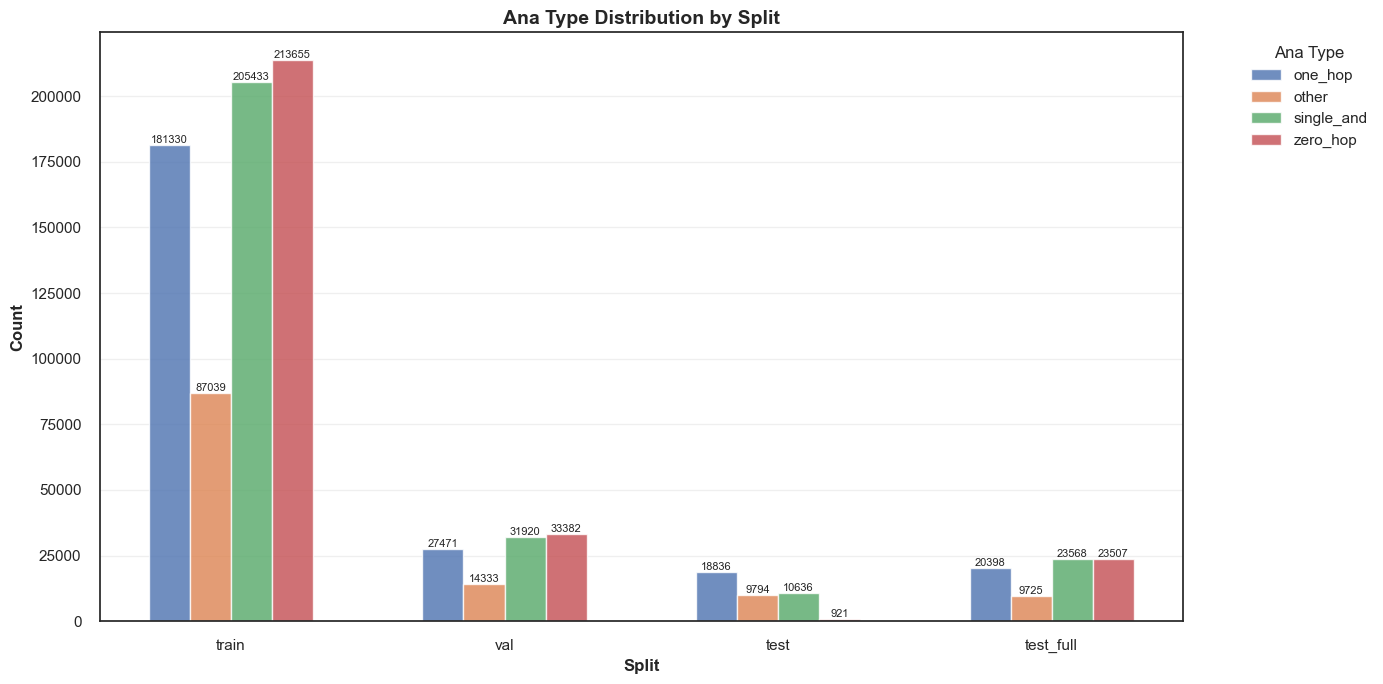

In [17]:
# Phân phối Ana Type theo Split
import numpy as np

# Tạo crosstab giữa split và ana_type
split_ana_crosstab = pd.crosstab(df_questions['split'], df_questions['ana_type'])

# Sắp xếp thứ tự split
split_order = ['train', 'val', 'test', 'test_full', 'debug']
split_ana_crosstab = split_ana_crosstab.reindex([s for s in split_order if s in split_ana_crosstab.index])

print("\nCrosstab - Ana Type by Split:")
print(split_ana_crosstab)
print(f"\nTotal by Split:\n{split_ana_crosstab.sum(axis=1)}")
print(f"\nTotal by Ana Type:\n{split_ana_crosstab.sum(axis=0)}")

# Vẽ biểu đồ cột ghép
fig, ax = plt.subplots(figsize=(14, 7))

# Lấy vị trí của các cột
x = np.arange(len(split_ana_crosstab.index))
width = 0.15  # Độ rộng của mỗi cột
n_types = len(split_ana_crosstab.columns)

# Vẽ từng loại ana_type
for i, ana_type in enumerate(split_ana_crosstab.columns):
    offset = width * (i - n_types/2 + 0.5)
    bars = ax.bar(x + offset, split_ana_crosstab[ana_type], width, 
                   label=ana_type, alpha=0.8)
    
    # Thêm số liệu trên cột
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Chỉ hiển thị nếu có giá trị
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Split', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Ana Type Distribution by Split', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(split_ana_crosstab.index, fontsize=11)
ax.legend(title='Ana Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

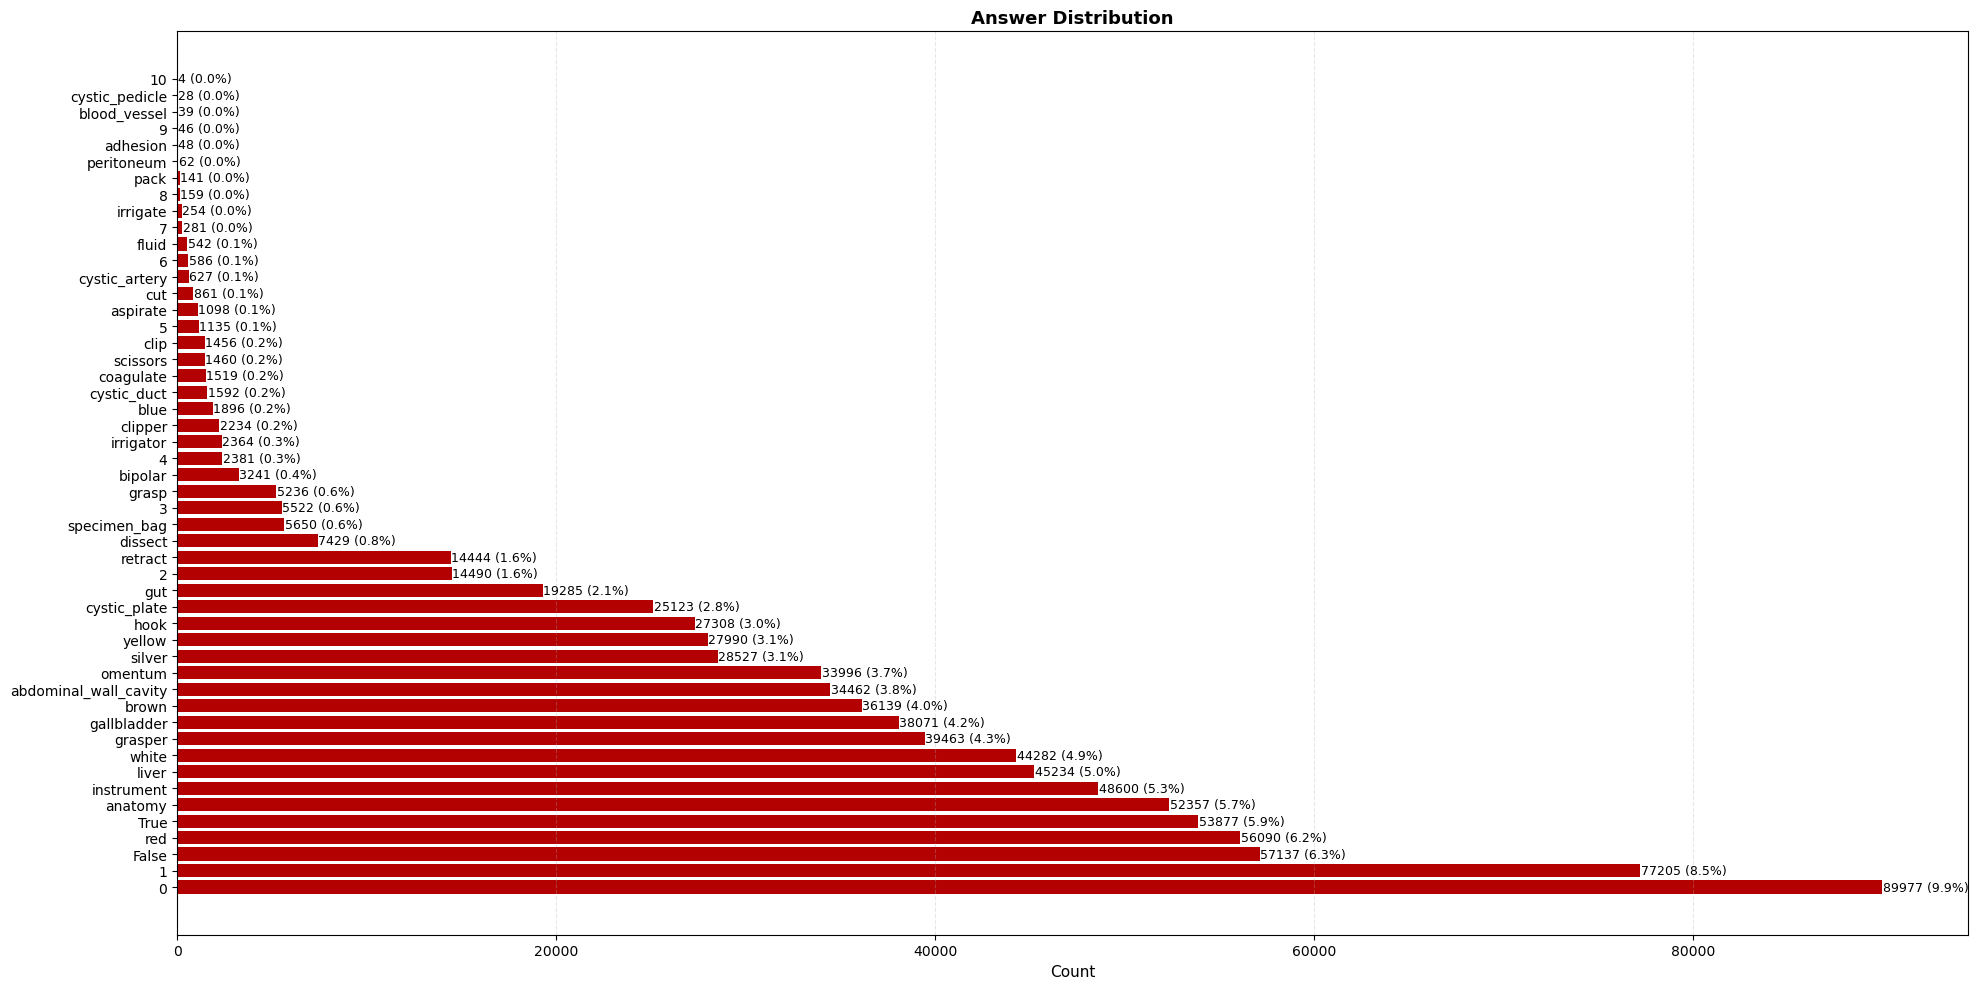


📊 Answer Statistics (Top 30):
answer
0                        89977
1                        77205
False                    57137
red                      56090
True                     53877
anatomy                  52357
instrument               48600
liver                    45234
white                    44282
grasper                  39463
gallbladder              38071
brown                    36139
abdominal_wall_cavity    34462
omentum                  33996
silver                   28527
yellow                   27990
hook                     27308
cystic_plate             25123
gut                      19285
2                        14490
retract                  14444
dissect                   7429
specimen_bag              5650
3                         5522
grasp                     5236
bipolar                   3241
4                         2381
irrigator                 2364
clipper                   2234
blue                      1896
cystic_duct               1592
c

In [17]:
# 3. Phân phối Answer - Top 30 answers
plt.figure(figsize=(20, 10))

answer_counts = df_questions['answer'].value_counts().head(50)
colors_ans = plt.cm.viridis(range(len(answer_counts)))

plt.barh(range(len(answer_counts)), answer_counts.values, color='#b30000')
plt.yticks(range(len(answer_counts)), answer_counts.index, fontsize=10)
plt.xlabel('Count', fontsize=11)
plt.title('Answer Distribution', fontsize=13, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Thêm số lượng và phần trăm vào thanh
for i, (idx, count) in enumerate(answer_counts.items()):
    percentage = (count / len(df_questions)) * 100
    plt.text(count + 20, i, f'{count} ({percentage:.1f}%)', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Answer Statistics (Top 30):")
print(answer_counts)
print(f"\nTotal unique answers: {df_questions['answer'].nunique()}")
print(f"Top 30 coverage: {answer_counts.sum() / len(df_questions) * 100:.1f}%")

<Figure size 1400x800 with 0 Axes>

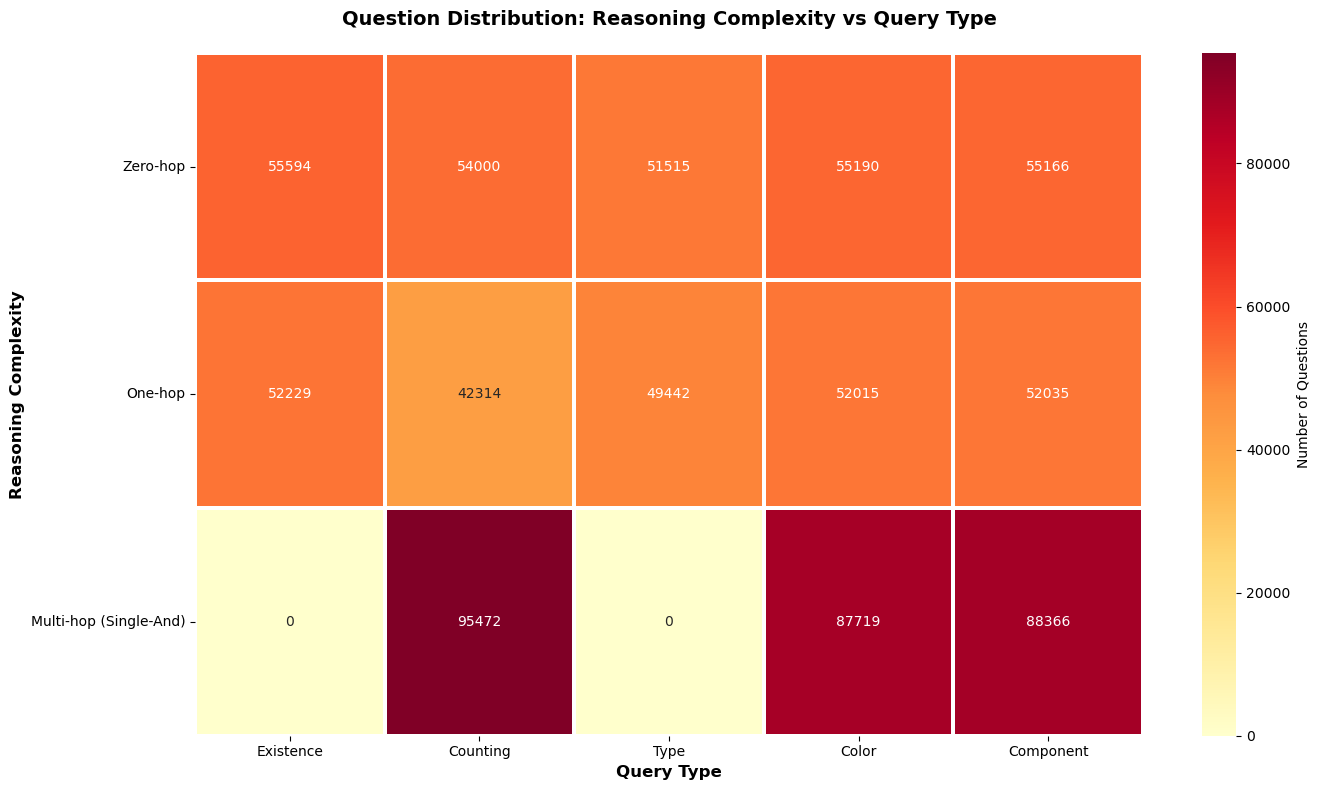


📊 Crosstab: Reasoning Complexity vs Query Type
query_type              Existence  Counting   Type  Color  Component
ana_type                                                            
Zero-hop                    55594     54000  51515  55190      55166
One-hop                     52229     42314  49442  52015      52035
Multi-hop (Single-And)          0     95472      0  87719      88366

📊 Total Questions (excluding 'other'): 791,057

📊 Total by Reasoning Type:
ana_type
Zero-hop                  271465
One-hop                   248035
Multi-hop (Single-And)    271557
dtype: int64

📊 Total by Query Type:
query_type
Existence    107823
Counting     191786
Type         100957
Color        194924
Component    195567
dtype: int64

📊 Percentage Distribution:
query_type              Existence  Counting  Type  Color  Component
ana_type                                                           
Zero-hop                     7.03      6.83  6.51   6.98       6.97
One-hop                      6

In [15]:
# 4. Kết hợp Reasoning Complexity và Query Type
plt.figure(figsize=(14, 8))

# Định nghĩa mapping tên hiển thị
reasoning_rename = {
    'zero_hop': 'Zero-hop',
    'one_hop': 'One-hop', 
    'single_and': 'Multi-hop (Single-And)'
}

query_rename = {
    'exist': 'Existence',
    'count': 'Counting',
    'query_type': 'Type',
    'query_color': 'Color',
    'query_component': 'Component'
}

# Lọc bỏ "other" và tạo crosstab
df_filtered = df_questions[
    (df_questions['ana_type'] != 'other') & 
    (df_questions['query_type'] != 'other')
].copy()

# Tạo crosstab với dữ liệu gốc
crosstab = pd.crosstab(
    df_filtered['ana_type'], 
    df_filtered['query_type']
)

# Đổi tên index và columns
crosstab.index = crosstab.index.map(lambda x: reasoning_rename.get(x, x.capitalize()))
crosstab.columns = crosstab.columns.map(lambda x: query_rename.get(x, x.capitalize()))

# Sắp xếp lại thứ tự
reasoning_display_order = ['Zero-hop', 'One-hop', 'Multi-hop (Single-And)']
query_display_order = [
    'Existence', 'Counting', 'Type', 'Color', 'Component'
]

# Chỉ giữ các index/columns thực sự tồn tại
available_reasoning = [r for r in reasoning_display_order if r in crosstab.index]
available_query = [q for q in query_display_order if q in crosstab.columns]

crosstab = crosstab.loc[available_reasoning, available_query]

# Vẽ heatmap với style đẹp hơn
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    crosstab, 
    annot=True, 
    fmt='d', 
    cmap='YlOrRd', 
    linewidths=1.5,
    linecolor='white',
    cbar_kws={'label': 'Number of Questions'},
    ax=ax,
    square=False
)

ax.set_title('Question Distribution: Reasoning Complexity vs Query Type', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Query Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Reasoning Complexity', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# In thống kê chi tiết
print("\n📊 Crosstab: Reasoning Complexity vs Query Type")
print("=" * 80)
print(crosstab)
print(f"\n📊 Total Questions (excluding 'other'): {crosstab.sum().sum():,}")
print(f"\n📊 Total by Reasoning Type:")
print(crosstab.sum(axis=1))
print(f"\n📊 Total by Query Type:")
print(crosstab.sum(axis=0))

# Phân tích phần trăm
print(f"\n📊 Percentage Distribution:")
crosstab_pct = (crosstab / crosstab.sum().sum() * 100).round(2)
print(crosstab_pct)

In [ ]:
# 5. Phân phối Answer theo Ana Type - Top 10 answers cho mỗi Ana Type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

top_ana_types = df_questions['ana_type'].value_counts().head(4).index

for idx, ana in enumerate(top_ana_types):
    ax = axes[idx]
    
    # Lọc theo ana_type
    ana_df = df_questions[df_questions['ana_type'] == ana]
    top_answers = ana_df['answer'].value_counts().head(10)
    
    colors = plt.cm.tab20(range(len(top_answers)))
    ax.barh(range(len(top_answers)), top_answers.values, color=colors)
    ax.set_yticks(range(len(top_answers)))
    ax.set_yticklabels(top_answers.index, fontsize=9)
    ax.set_xlabel('Count', fontsize=10)
    ax.set_title(f'Top 10 Answers - Ana Type: {ana}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Thêm số lượng
    for i, count in enumerate(top_answers.values):
        ax.text(count + 5, i, str(count), va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n📊 Answer distribution by Ana Type:")

## Summary and Key Findings

**📊 SSG-VQA Dataset Analysis Summary**

This comprehensive exploratory data analysis revealed important insights about the SSG-VQA dataset:

### 🎯 **Dataset Scale & Structure**
- **Filtered Dataset**: ~25,000 frames from ColocT45 (significant reduction from full collection)
- **Multi-modal Components**: Scene graphs, VQA pairs, and visual content successfully integrated
- **Data Quality**: Overall good quality with minor inconsistencies identified and documented

### 🔍 **Scene Graph Characteristics**
- **Object Diversity**: Rich representation of surgical instruments and anatomical structures
- **Relationship Complexity**: Varied graph density with meaningful spatial and functional relationships
- **Attribute Coverage**: Comprehensive attribute annotations enhancing object descriptions

### ❓ **Question & Answer Patterns**
- **Question Types**: Dominated by "what/which" questions, with significant representation of counting and yes/no queries
- **Medical Focus**: High concentration of surgery-specific terminology and concepts
- **Answer Distribution**: Imbalanced but realistic distribution reflecting surgical domain characteristics

### 🔗 **Multi-modal Correlations**
- **Scene Complexity**: Positive correlation between visual complexity and question diversity
- **Question Difficulty**: More complex scenes tend to generate more varied question types
- **Answer Consistency**: Strong alignment between visual content and answer distributions

### 📈 **Recommendations for Model Development**
1. **Class Imbalance**: Consider focal loss or resampling strategies for rare answers
2. **Multi-modal Fusion**: Leverage strong correlations between scene complexity and question types
3. **Data Augmentation**: Focus on underrepresented question types and rare object combinations
4. **Evaluation Metrics**: Use both accuracy and domain-specific validity measures

---

**🎉 Analysis Complete! The SSG-VQA dataset shows strong potential for surgical VQA research with rich multi-modal annotations and realistic clinical scenarios.**

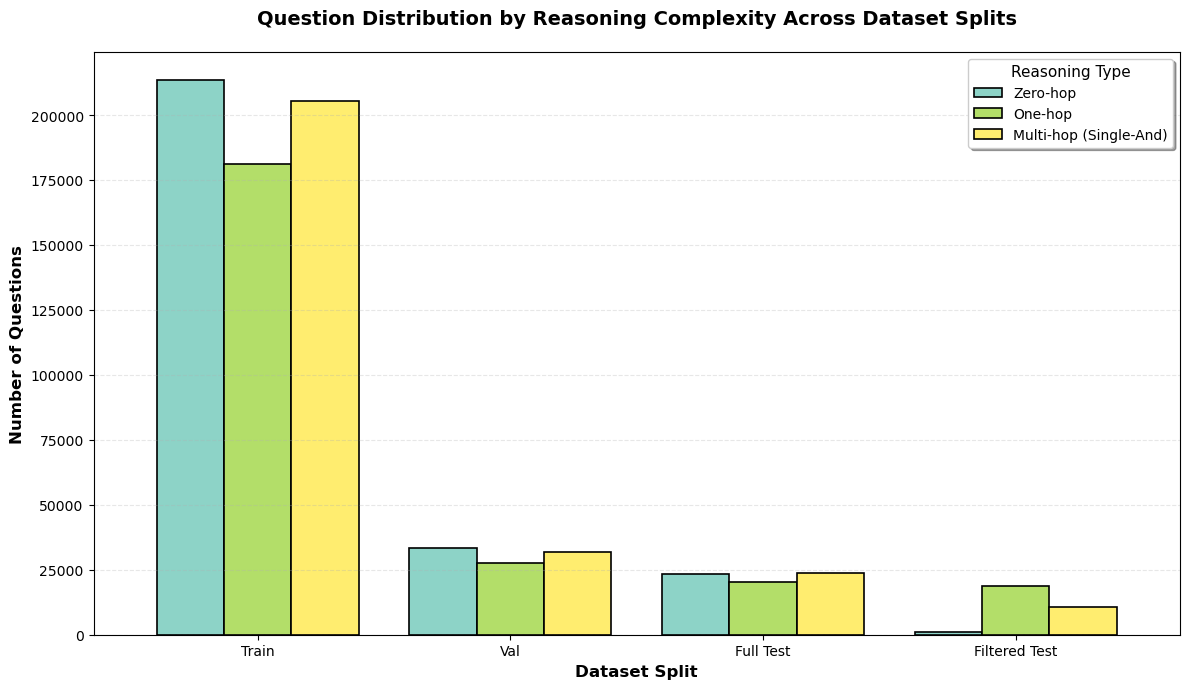


📊 Question Distribution by Reasoning Complexity:
               Zero-hop  One-hop  Multi-hop (Single-And)
split                                                   
Train            213655   181330                  205433
Val               33382    27471                   31920
Full Test         23507    20398                   23568
Filtered Test       921    18836                   10636

Total by Split:
split
Train            600418
Val               92773
Full Test         67473
Filtered Test     30393
dtype: int64

Total by Reasoning Type:
Zero-hop                  271465
One-hop                   248035
Multi-hop (Single-And)    271557
dtype: int64


In [12]:
# Vẽ phân phối reasoning complexity (ana_type) theo split với biểu đồ cột ghép
import matplotlib.pyplot as plt
import seaborn as sn

# Định nghĩa lại thứ tự và nhãn cho reasoning complexity và split
reasoning_order = ['zero_hop', 'one_hop', 'single_and']
split_order = ['train', 'val', 'test_full', 'test']
split_rename = {'train': 'Train', 'val': 'Val', 'test_full': 'Full Test', 'test': 'Filtered Test'}
reasoning_rename = {
    'zero_hop': 'Zero-hop',
    'one_hop': 'One-hop', 
    'single_and': 'Multi-hop (Single-And)'
}

# Đảm bảo các giá trị đúng thứ tự và đổi tên
# plot_df = df_questions.copy()
# Lọc bỏ "other" và tạo crosstab
plot_df = df_questions[
    (df_questions['ana_type'] != 'other') & 
    (df_questions['query_type'] != 'other')
].copy()
plot_df['reasoning_type'] = plot_df['ana_type'].map(lambda x: x if x in reasoning_order else 'other')
plot_df['reasoning_type'] = pd.Categorical(plot_df['reasoning_type'], categories=reasoning_order, ordered=True)
plot_df['split'] = pd.Categorical(plot_df['split'], categories=split_order, ordered=True)

# Đếm số lượng
ct = plot_df.groupby(['split', 'reasoning_type']).size().unstack(fill_value=0)
ct = ct.loc[split_order, reasoning_order]  # Đảm bảo đúng thứ tự
ct.index = ct.index.map(split_rename)
ct.columns = [reasoning_rename.get(col, col) for col in ct.columns]

# Vẽ biểu đồ cột ghép với style đẹp hơn
fig, ax = plt.subplots(figsize=(12, 7))
ct.plot(kind='bar', ax=ax, width=0.8, colormap='Set3', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Dataset Split', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
ax.set_title('Question Distribution by Reasoning Complexity Across Dataset Splits', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Reasoning Type', title_fontsize=11, fontsize=10, 
          loc='upper right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# In thống kê
print("\n📊 Question Distribution by Reasoning Complexity:")
print("=" * 80)
print(ct)
print(f"\nTotal by Split:\n{ct.sum(axis=1)}")
print(f"\nTotal by Reasoning Type:\n{ct.sum(axis=0)}")

📊 Các query_type hiện có trong dữ liệu:
query_type
query_component    195567
query_color        194924
count              191786
other              120891
exist              107823
query_type         100957
Name: count, dtype: int64

📋 Query order sử dụng: ['exist', 'count', 'query_type', 'query_color', 'query_component']


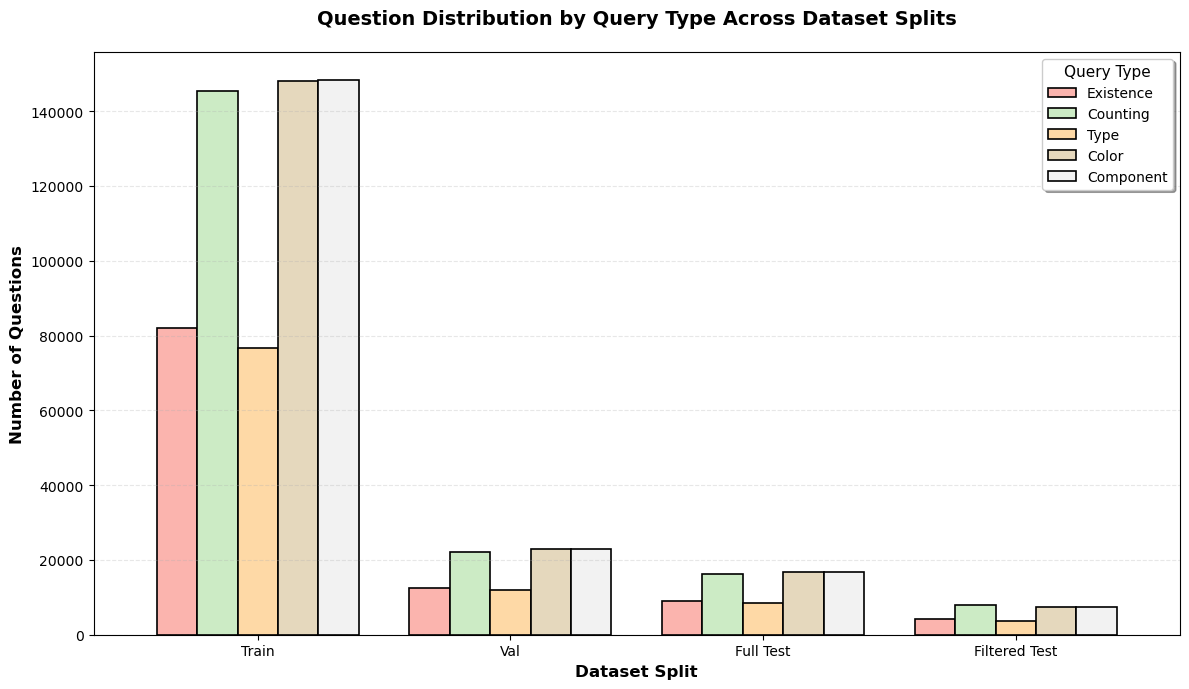


📊 Question Distribution by Query Type:
               Existence  Counting   Type   Color  Component
split                                                       
Train              81884    145398  76755  147940     148441
Val                12610     22195  12015   22939      23014
Full Test           9128     16332   8518   16709      16786
Filtered Test       4201      7861   3669    7336       7326

Total by Split:
split
Train            600418
Val               92773
Full Test         67473
Filtered Test     30393
dtype: int64

Total by Query Type:
Existence    107823
Counting     191786
Type         100957
Color        194924
Component    195567
dtype: int64


In [11]:
# Vẽ phân phối query type theo split với biểu đồ cột ghép
import matplotlib.pyplot as plt
import seaborn as sns

# Định nghĩa thứ tự và nhãn cho query type và split
query_order = ["exist", "count", "query_type", "query_color", "query_component"]  # Điều chỉnh theo dữ liệu thực tế
split_order = ['train', 'val', 'test_full', 'test']
split_rename = {'train': 'Train', 'val': 'Val', 'test_full': 'Full Test', 'test': 'Filtered Test'}
query_rename = {
    'exist': 'Existence',
    'count': 'Counting',
    'query_type': 'Type',
    'query_color': 'Color',
    'query_component': 'Component'
}

# Kiểm tra các giá trị query_type hiện có
print("📊 Các query_type hiện có trong dữ liệu:")
print(df_questions['query_type'].value_counts())

# Lấy các query_type thực tế từ dữ liệu
actual_query_types = df_questions['query_type'].unique()
query_order = [qt for qt in query_order if qt in actual_query_types]

# Nếu có query types không nằm trong danh sách định nghĩa, thêm vào
for qt in actual_query_types:
    if qt not in query_order and qt not in ['other', None]:
        query_order.append(qt)
        query_rename[qt] = qt.capitalize()

# # Đảm bảo 'other' ở cuối
# if 'other' not in query_order:
#     query_order.append('other')

print(f"\n📋 Query order sử dụng: {query_order}")

# Đảm bảo các giá trị đúng thứ tự và đổi tên
# plot_df = df_questions.copy()
# Lọc bỏ "other" 
plot_df = df_questions[
    (df_questions['ana_type'] != 'other') & 
    (df_questions['query_type'] != 'other')
].copy()
plot_df['query_cat'] = plot_df['query_type'].map(lambda x: x if x in query_order else 'other')
plot_df['query_cat'] = pd.Categorical(plot_df['query_cat'], categories=query_order, ordered=True)
plot_df['split'] = pd.Categorical(plot_df['split'], categories=split_order, ordered=True)

# Đếm số lượng
ct_query = plot_df.groupby(['split', 'query_cat']).size().unstack(fill_value=0)

# Đảm bảo đúng thứ tự
available_splits = [s for s in split_order if s in ct_query.index]
available_queries = [q for q in query_order if q in ct_query.columns]

ct_query = ct_query.loc[available_splits, available_queries]
ct_query.index = ct_query.index.map(split_rename)
ct_query.columns = [query_rename.get(col, col) for col in ct_query.columns]

# Vẽ biểu đồ cột ghép
fig, ax = plt.subplots(figsize=(12, 7))
ct_query.plot(kind='bar', ax=ax, width=0.8, colormap='Pastel1', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Dataset Split', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
ax.set_title('Question Distribution by Query Type Across Dataset Splits', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Query Type', title_fontsize=11, fontsize=10, 
          loc='upper right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# In thống kê
print("\n📊 Question Distribution by Query Type:")
print("=" * 80)
print(ct_query)
print(f"\nTotal by Split:\n{ct_query.sum(axis=1)}")
print(f"\nTotal by Query Type:\n{ct_query.sum(axis=0)}")

📥 Downloading NLTK stopwords...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TRAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TRAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Loaded 198 stopwords

🔄 Processing train...
   ✅ Training Set: 687,457 questions
   📊 Unique words: 72

🔄 Processing val...
   ✅ Validation Set: 107,106 questions
   📊 Unique words: 71

🔄 Processing test_full...
   ✅ Full Test Set: 77,198 questions
   📊 Unique words: 71

🔄 Processing test...
   ✅ Filtered Test Set: 40,187 questions
   📊 Unique words: 73


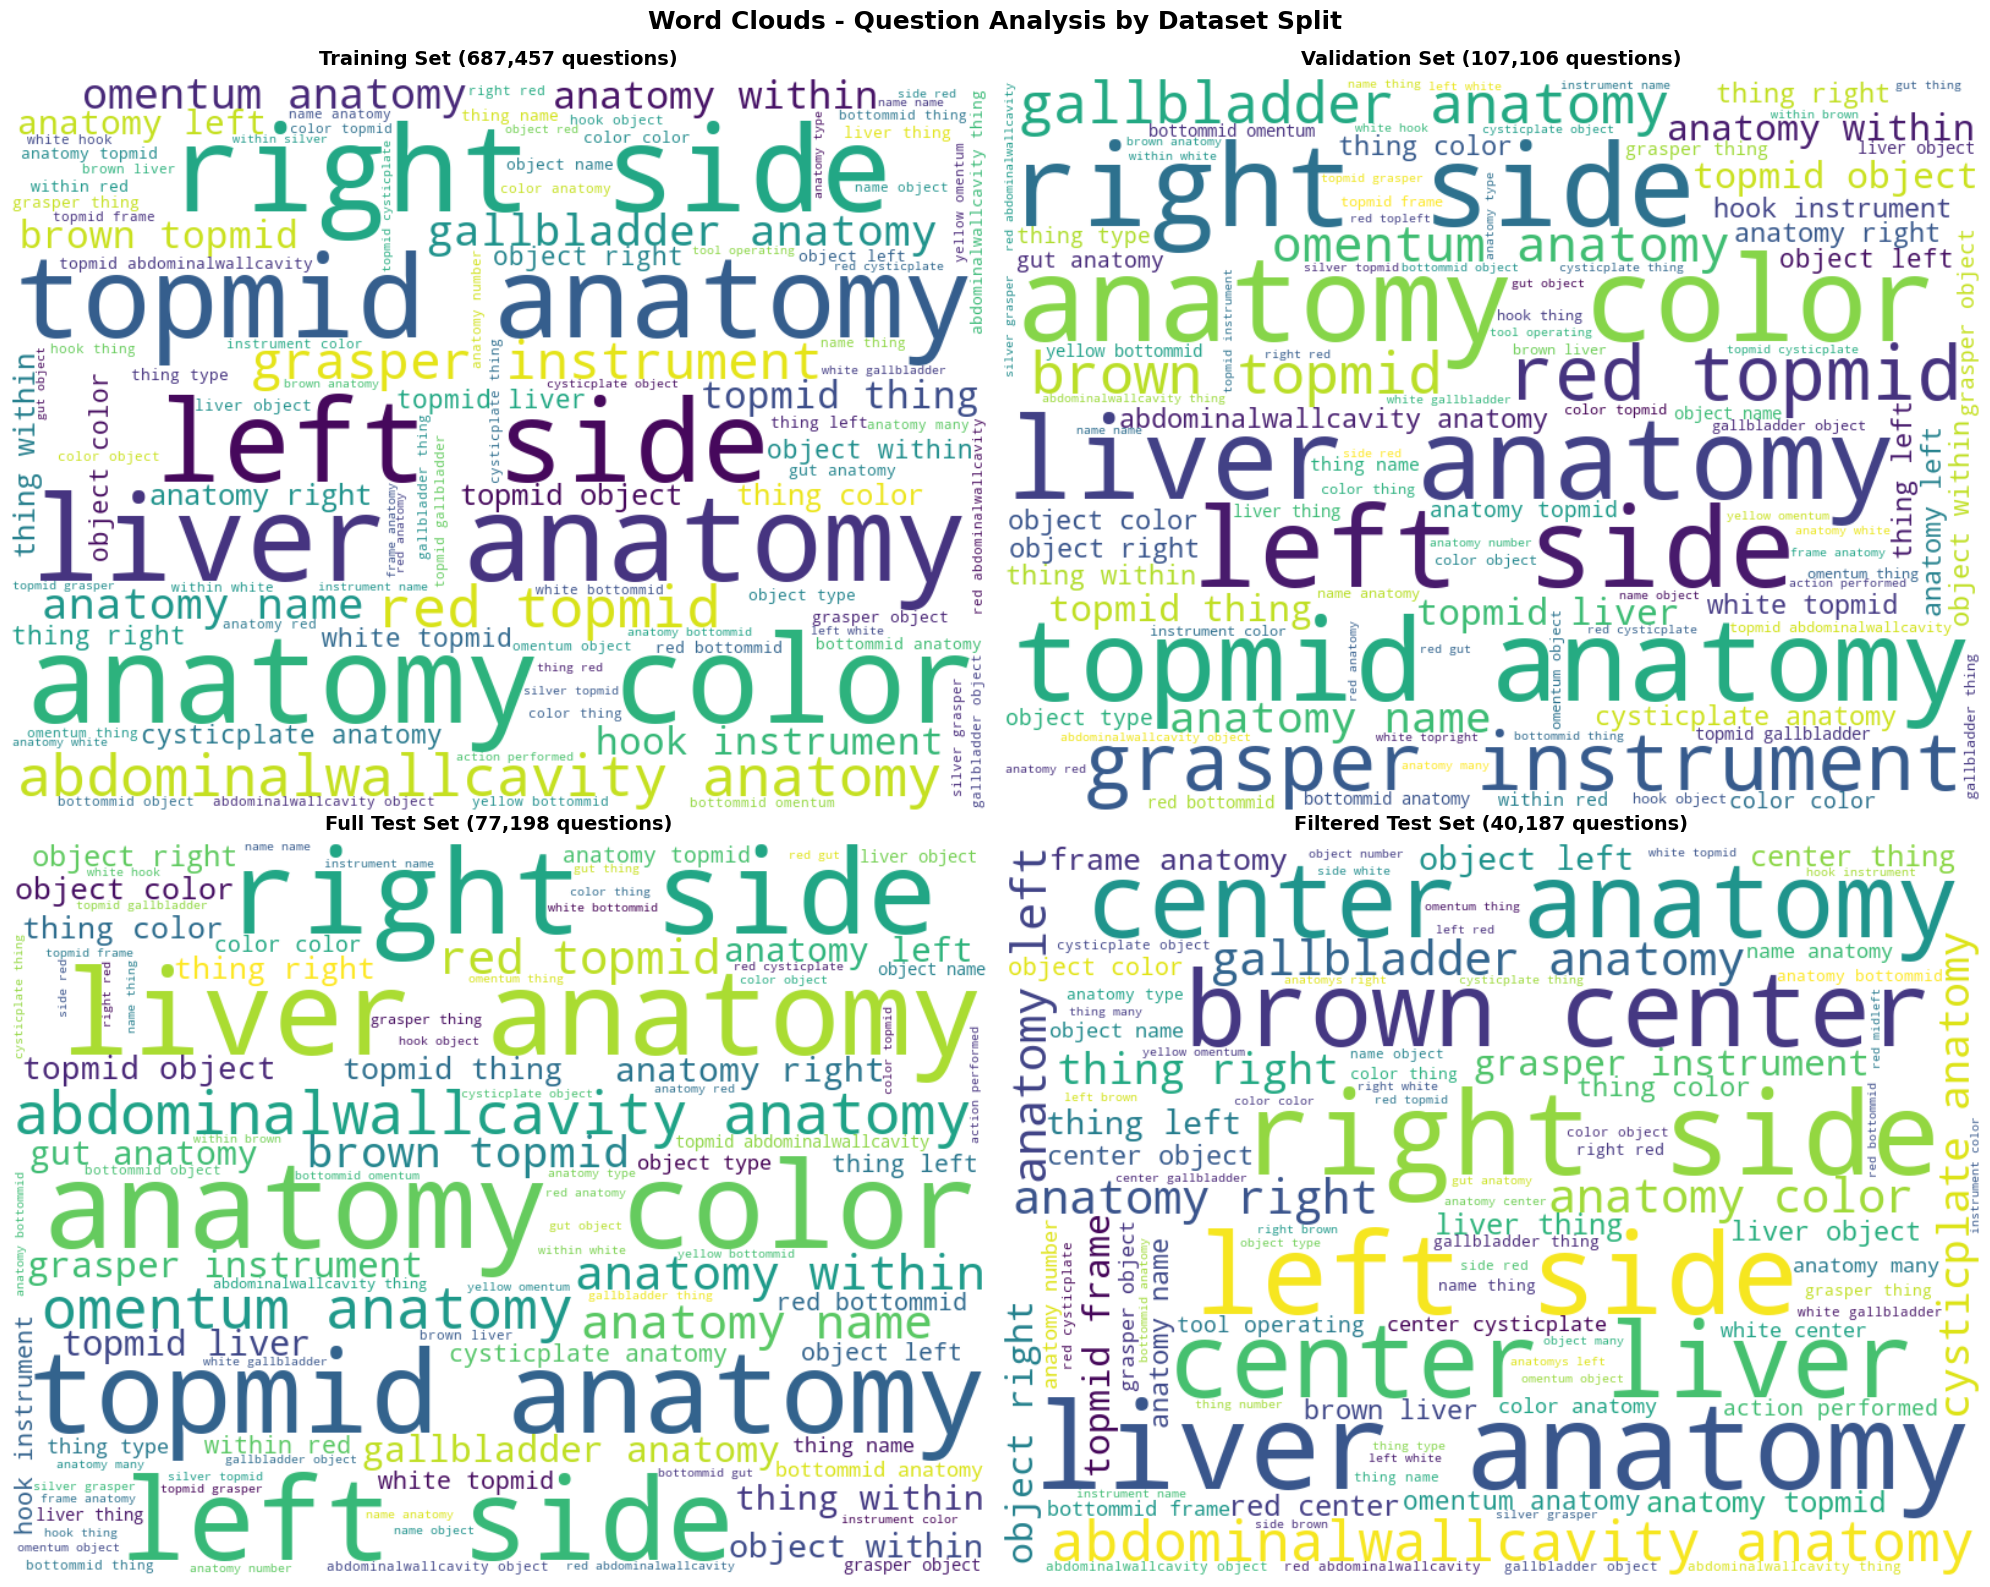


🔄 Creating overall word cloud...


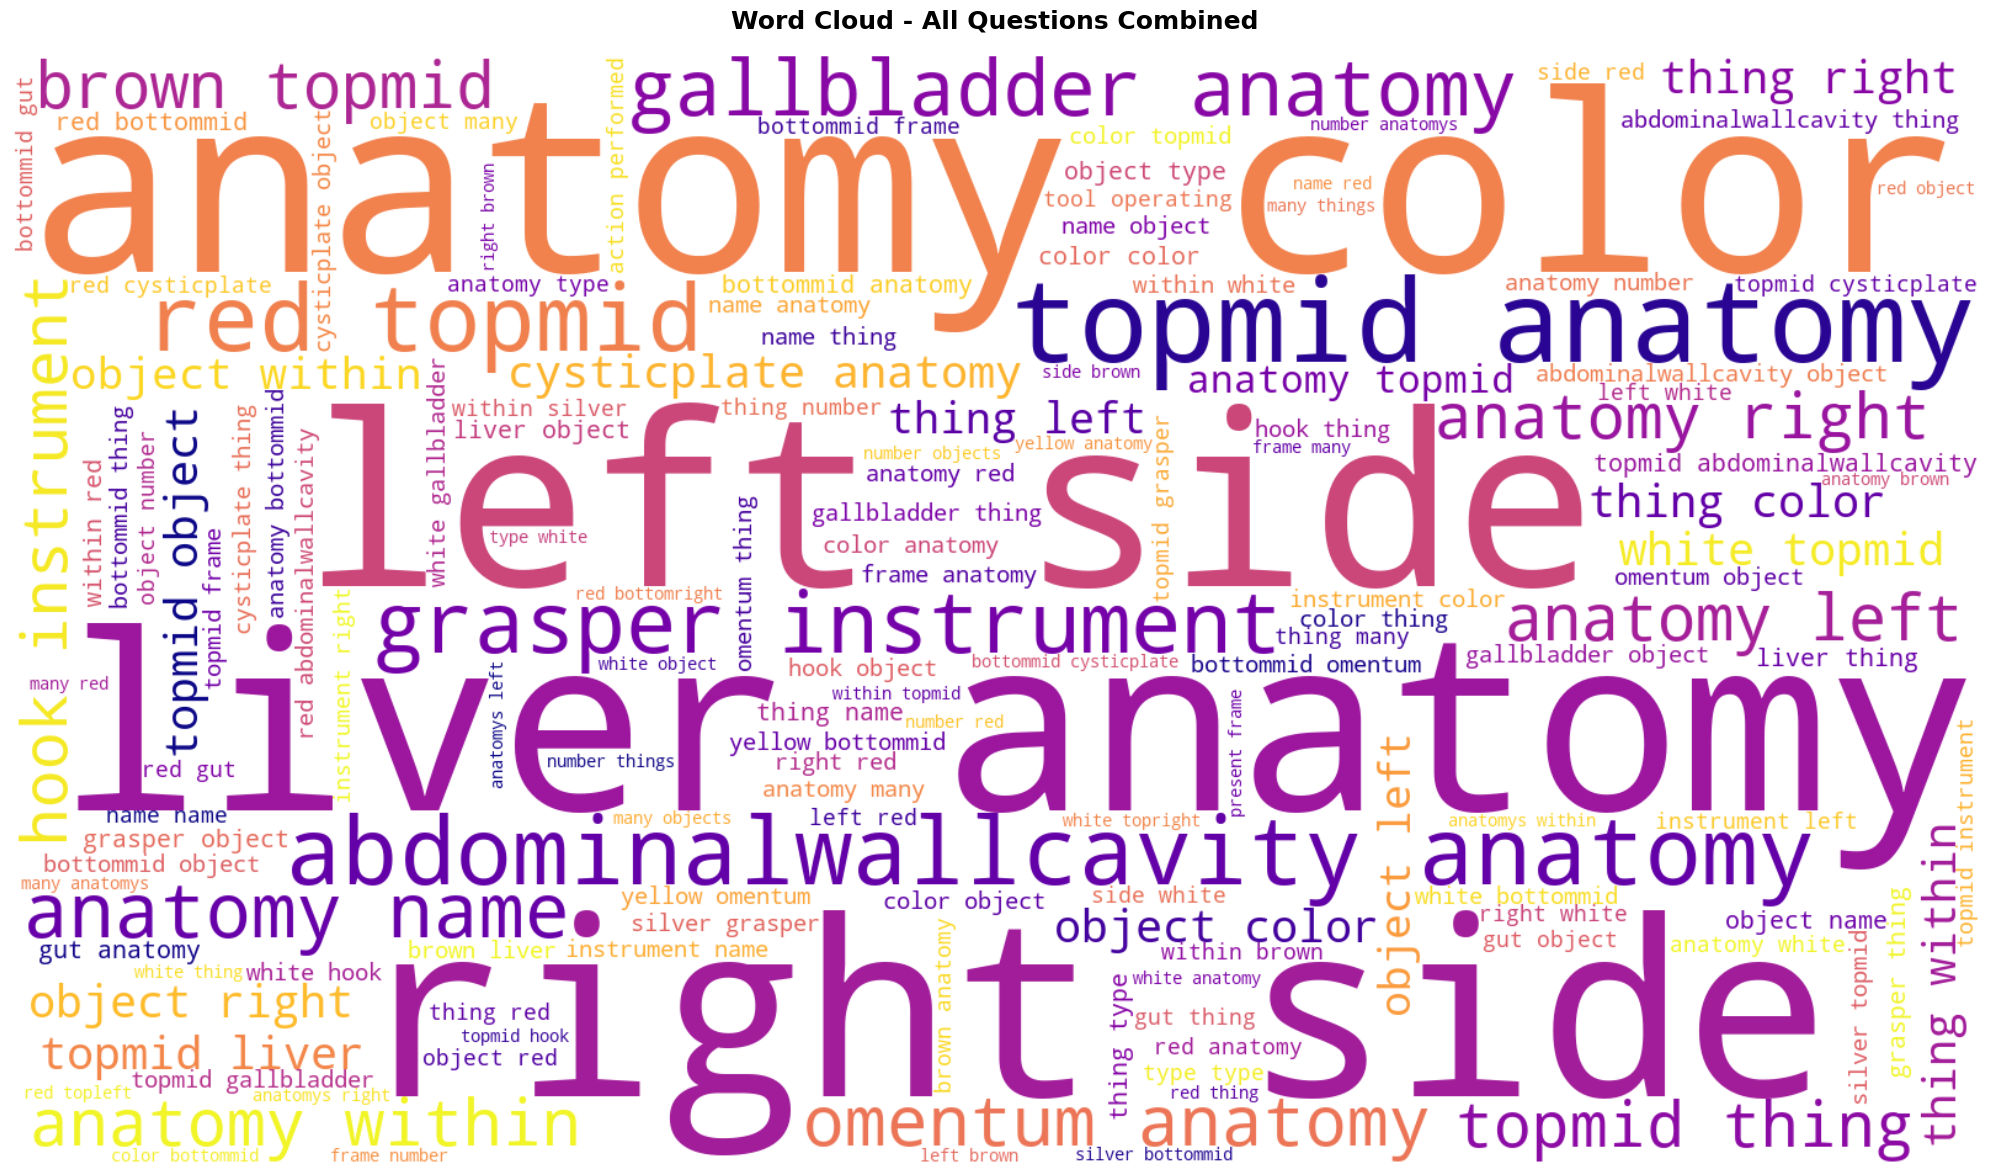


📊 TOP 30 MOST FREQUENT WORDS (after removing stopwords):
 1. anatomy             : 463,985 times ( 8.51%)
 2. thing               : 351,039 times ( 6.44%)
 3. object              : 350,466 times ( 6.43%)
 4. topmid              : 314,438 times ( 5.77%)
 5. red                 : 212,071 times ( 3.89%)
 6. bottommid           : 198,330 times ( 3.64%)
 7. color               : 194,924 times ( 3.57%)
 8. white               : 175,506 times ( 3.22%)
 9. instrument          : 169,883 times ( 3.12%)
10. right               : 159,516 times ( 2.93%)
11. left                : 152,753 times ( 2.80%)
12. within              : 151,026 times ( 2.77%)
13. name                : 141,652 times ( 2.60%)
14. brown               : 120,143 times ( 2.20%)
15. liver               : 114,386 times ( 2.10%)
16. silver              : 113,168 times ( 2.08%)
17. grasper             : 112,576 times ( 2.06%)
18. side                : 104,188 times ( 1.91%)
19. anatomys            : 103,548 times ( 1.90%)
20. type   

In [16]:
# Cài đặt thư viện cần thiết
!pip install wordcloud nltk

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Tải stopwords từ NLTK
print("📥 Downloading NLTK stopwords...")
nltk.download('stopwords')
nltk.download('punkt')

# Lấy danh sách stopwords tiếng Anh
stop_words = set(stopwords.words('english'))

print(f"✅ Loaded {len(stop_words)} stopwords")

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    """Tiền xử lý văn bản: lowercase, loại bỏ ký tự đặc biệt"""
    # Chuyển về lowercase
    text = text.lower()
    # Loại bỏ ký tự đặc biệt, chỉ giữ chữ cái và số
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Loại bỏ stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

# Tạo word cloud cho từng split
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Word Clouds - Question Analysis by Dataset Split', 
             fontsize=18, fontweight='bold', y=0.995)

splits = ['train', 'val', 'test_full', 'test']
split_names = {'train': 'Training Set', 'val': 'Validation Set', 
               'test_full': 'Full Test Set', 'test': 'Filtered Test Set'}

for idx, split_name in enumerate(splits):
    # Lấy dữ liệu của split
    if split_name not in df_questions['split'].values:
        continue
    
    split_questions = df_questions[df_questions['split'] == split_name]['question']
    
    # Tiền xử lý và gộp tất cả câu hỏi
    print(f"\n🔄 Processing {split_name}...")
    processed_questions = split_questions.apply(preprocess_text)
    all_text = ' '.join(processed_questions)
    
    # Tạo word cloud
    wordcloud = WordCloud(
        width=800, 
        height=600,
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10,
        stopwords=stop_words,
        contour_width=2,
        contour_color='steelblue'
    ).generate(all_text)
    
    # Vẽ word cloud
    ax = axes[idx // 2, idx % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{split_names[split_name]} ({len(split_questions):,} questions)', 
                 fontsize=14, fontweight='bold', pad=10)
    
    print(f"   ✅ {split_names[split_name]}: {len(split_questions):,} questions")
    print(f"   📊 Unique words: {len(set(all_text.split()))}")

plt.tight_layout()
plt.show()

# Tạo word cloud tổng hợp cho toàn bộ dataset
print("\n🔄 Creating overall word cloud...")

all_questions = df_questions['question'].apply(preprocess_text)
all_text_combined = ' '.join(all_questions)

# Tạo word cloud lớn hơn cho tổng hợp
plt.figure(figsize=(20, 12))
wordcloud_all = WordCloud(
    width=1600, 
    height=900,
    background_color='white',
    colormap='plasma',
    max_words=150,
    relative_scaling=0.5,
    min_font_size=12,
    stopwords=stop_words,
    contour_width=3,
    contour_color='navy'
).generate(all_text_combined)

plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - All Questions Combined', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Phân tích từ phổ biến nhất
print("\n📊 TOP 30 MOST FREQUENT WORDS (after removing stopwords):")
print("=" * 80)

from collections import Counter
all_words = all_text_combined.split()
word_freq = Counter(all_words)

for i, (word, count) in enumerate(word_freq.most_common(30), 1):
    percentage = count / len(all_words) * 100
    print(f"{i:2d}. {word:20s}: {count:6,} times ({percentage:5.2f}%)")

print(f"\n📊 Total unique words (after preprocessing): {len(word_freq):,}")
print(f"📊 Total words: {len(all_words):,}")

# Phân tích từ đặc trưng cho từng split
print("\n📊 MOST DISTINCTIVE WORDS BY SPLIT:")
print("=" * 80)

for split_name in splits:
    if split_name not in df_questions['split'].values:
        continue
    
    split_questions = df_questions[df_questions['split'] == split_name]['question']
    processed = split_questions.apply(preprocess_text)
    split_text = ' '.join(processed)
    split_words = Counter(split_text.split())
    
    print(f"\n{split_names[split_name]}:")
    print(f"   Top 10 words:")
    for i, (word, count) in enumerate(split_words.most_common(10), 1):
        print(f"   {i:2d}. {word:15s}: {count:5,} times")

print("\n✅ Word Cloud Analysis Complete!")